# Machine Learning Pipeline
The work here expects that feature engineering has been applied to the data so all that needs to be done is reading in a data matrix and performing minimal preprocessing, feature selection, training, and performance metric ouptut. Everything is being done in a pipeline which runs straight from input to cv output, but I can fit it first and look at intermediate results if needed.
## Notes

## TODO
1. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from src.mlPipeline.modelTraining import performGridSearch, printBestModelStatistics
from src.mlPipeline.plotting import plotBestModelComparison, plotDatasetModelComparison
import pandas as pd
import pickle
import copy
import pprint
import glob
pp = pprint.PrettyPrinter(indent=4)

In [2]:
dataPath = "data/MLData/pbr_ml_project_datasets_20180423/"
# dataPrefix = "dataset_2_"
modelDictPicklePath = "data/modelDictMultiDataRun.pkl"

# Search for the Best Model
Searching for the best model runs over all 14 datasets, and many feature selection/model tuning parameters so it can take a while. I suggest that you load the model from the pickle file which can be executed below. 


## Attention
Please note that the cell directly below this one iterates over datasets lebaled 11, and 12, while the next cell iterates over all datasets. Our project has focused on only datasets 11 and 12, but we have the capability/results to report on all datasets. If you're sure that you want to run the entire pipeline (which can take hours) run the second cell. Running only the first cell shouldn't take too long. After which you should load the original saved files to see all plotting of model performance. Even running on the smaller subset of data can take a while as there are many parameters to iterate over for hyperparameter tuning

In [4]:

allDataModelDict = {}
for i in range(11, 13):
    dataPath = "data/MLData/pbr_ml_project_datasets_20180423/"
    dataPrefix = "dataset_{}_".format(i)
    print("Running model search on data {}".format(dataPrefix))
    allDataModelDict[dataPrefix] = performGridSearch(dataPath = dataPath, dataPrefix = dataPrefix)
    print("\n\n\n\n\n")

Running model search on data dataset_11_
performing grid search
X shape: (308, 2229)
Y positive examples: 145
Using 5 fold cv
Choosing the best model based on roc_auc
Gwas Cutoff [0.0]
Training logistic
For Model logistic:
	accuracy: 0.74
	f1: 0.666
	precision: 0.827
	recall: 0.6
	roc_auc: 0.825
Best Model Parameters {'feature_union__gwasFeatures__gwasCutoff': 0.0, 'feature_union__linSVC_dimReduction__estimator__C': 0.25, 'feature_union__linSVC_dimReduction__threshold': 'mean', 'logistic__C': 1, 'logistic__penalty': 'l1'}
****************************************************************************************************
Training randomForest
For Model randomForest:
	accuracy: 0.727
	f1: 0.662
	precision: 0.808
	recall: 0.594
	roc_auc: 0.825
Best Model Parameters {'RFC__criterion': 'gini', 'RFC__max_depth': None, 'RFC__max_features': 0.5, 'RFC__n_estimators': 20, 'feature_union__gwasFeatures__gwasCutoff': 0.0, 'feature_union__linSVC_dimReduction__estimator__C': 1, 'feature_union__linSV

In [65]:

allDataModelDict = {}
for i in range(1, 15):
    dataPath = "data/MLData/pbr_ml_project_datasets_20180423/"
    dataPrefix = "dataset_{}_".format(i)
    print("Running model search on data {}".format(dataPrefix))
    allDataModelDict[dataPrefix] = performGridSearch(dataPath = dataPath, dataPrefix = dataPrefix)
    print("\n\n\n\n\n")

Running model search on data dataset_1_
performing grid search
X shape: (432, 2229)
Y positive examples: 147
Using 5 fold cv
Choosing the best model based on roc_auc
Gwas Cutoff [0.0]
Training logistic
For Model logistic:
	accuracy: 0.757
	f1: 0.678
	precision: 0.724
	recall: 0.694
	roc_auc: 0.807
Best Model Parameters {'feature_union__gwasFeatures__gwasCutoff': 0.0, 'feature_union__linSVC_dimReduction__estimator__C': 10, 'feature_union__linSVC_dimReduction__threshold': 'mean', 'logistic__C': 1, 'logistic__penalty': 'l1'}
****************************************************************************************************
Training randomForest
For Model randomForest:
	accuracy: 0.718
	f1: 0.645
	precision: 0.725
	recall: 0.686
	roc_auc: 0.805
Best Model Parameters {'RFC__criterion': 'gini', 'RFC__max_depth': None, 'RFC__max_features': 0.5, 'RFC__n_estimators': 15, 'feature_union__gwasFeatures__gwasCutoff': 0.0, 'feature_union__linSVC_dimReduction__estimator__C': 10, 'feature_union__linS

For Model GBTC:
	accuracy: 0.783
	f1: 0.412
	precision: 0.438
	recall: 0.389
	roc_auc: 0.819
Best Model Parameters {'GBTC__learning_rate': 0.1, 'GBTC__max_depth': 5, 'GBTC__n_estimators': 50, 'feature_union__gwasFeatures__gwasCutoff': 0.20000000000000001, 'feature_union__linSVC_dimReduction__estimator__C': 0.75, 'feature_union__linSVC_dimReduction__threshold': 0.25}
****************************************************************************************************






Running model search on data dataset_5_
performing grid search
X shape: (201, 2229)
Y positive examples: 118
Using 5 fold cv
Choosing the best model based on roc_auc
Gwas Cutoff [0.0]
Training logistic
For Model logistic:
	accuracy: 0.662
	f1: 0.707
	precision: 0.714
	recall: 0.703
	roc_auc: 0.774
Best Model Parameters {'feature_union__gwasFeatures__gwasCutoff': 0.0, 'feature_union__linSVC_dimReduction__estimator__C': 100, 'feature_union__linSVC_dimReduction__threshold': 'mean', 'logistic__C': 1, 'logistic__penalty': '

For Model SVC:
	accuracy: 0.559
	f1: 0.717
	precision: 0.559
	recall: 1.0
	roc_auc: 0.791
Best Model Parameters {'SVC__C': 0.5, 'SVC__kernel': 'poly', 'feature_union__gwasFeatures__gwasCutoff': 0.20000000000000001, 'feature_union__linSVC_dimReduction__estimator__C': 0.75, 'feature_union__linSVC_dimReduction__threshold': 0.25}
****************************************************************************************************
Training GBTC
For Model GBTC:
	accuracy: 0.794
	f1: 0.811
	precision: 0.833
	recall: 0.789
	roc_auc: 0.867
Best Model Parameters {'GBTC__learning_rate': 0.1, 'GBTC__max_depth': 10, 'GBTC__n_estimators': 400, 'feature_union__gwasFeatures__gwasCutoff': 0.0, 'feature_union__linSVC_dimReduction__estimator__C': 0.25, 'feature_union__linSVC_dimReduction__threshold': 0.25}
****************************************************************************************************






Running model search on data dataset_9_
performing grid search
X shape: (231, 2229)
Y positive 

For Model randomForest:
	accuracy: 0.792
	f1: 0.758
	precision: 0.781
	recall: 0.735
	roc_auc: 0.861
Best Model Parameters {'RFC__criterion': 'gini', 'RFC__max_depth': None, 'RFC__max_features': 0.5, 'RFC__n_estimators': 20, 'feature_union__gwasFeatures__gwasCutoff': 0.0, 'feature_union__linSVC_dimReduction__estimator__C': 0.25, 'feature_union__linSVC_dimReduction__threshold': 'mean'}
****************************************************************************************************
Training SVC
For Model SVC:
	accuracy: 0.792
	f1: 0.765
	precision: 0.765
	recall: 0.765
	roc_auc: 0.869
Best Model Parameters {'SVC__C': 10, 'SVC__kernel': 'rbf', 'feature_union__gwasFeatures__gwasCutoff': 0.20000000000000001, 'feature_union__linSVC_dimReduction__estimator__C': 10, 'feature_union__linSVC_dimReduction__threshold': 0.25}
****************************************************************************************************
Training GBTC
For Model GBTC:
	accuracy: 0.805
	f1: 0.776
	precision: 0

# Plotting performance results
Though you can run the model selectuion process on a subset of the datasets, and the code will work with any combination of datasets provided the right arguments are given, it is suggested to simply reload the saved pickle dictionary in order to plot all performance results

In [ ]:
# modelDictPicklePath = "data/modelDictMultiDataRun.pkl"
# with open(modelDictPicklePath, "wb") as pklFile:
#     pickle.dump(modelDictHolder, pklFile)

In [3]:
with open(modelDictPicklePath, "rb") as pklFile:
    allDataModelDict = pickle.load(pklFile)

0.0 f1 score found. Model logistic is not counted
0.0 f1 score found. Model randomForest is not counted
0.0 f1 score found. Model SVC is not counted
0.0 f1 score found. Model GBTC is not counted
Dataset with all zero f1 scores are being removed from plots
{   'dataset_10_': ('', 0, -1, 0, -1),
    'dataset_11_': (   'logistic',
                       0.82570170327321579,
                       0.054070431583182747,
                       0.66629538061788907,
                       0.12104868621131465),
    'dataset_12_': (   'logistic',
                       0.87585499316005477,
                       0.0,
                       0.82352941176470584,
                       0.0),
    'dataset_13_': (   'logistic',
                       0.76513169799939684,
                       0.1208257975804005,
                       0.63569002845818234,
                       0.10225950467924015),
    'dataset_14_': (   'randomForest',
                       0.86703296703296706,
                  

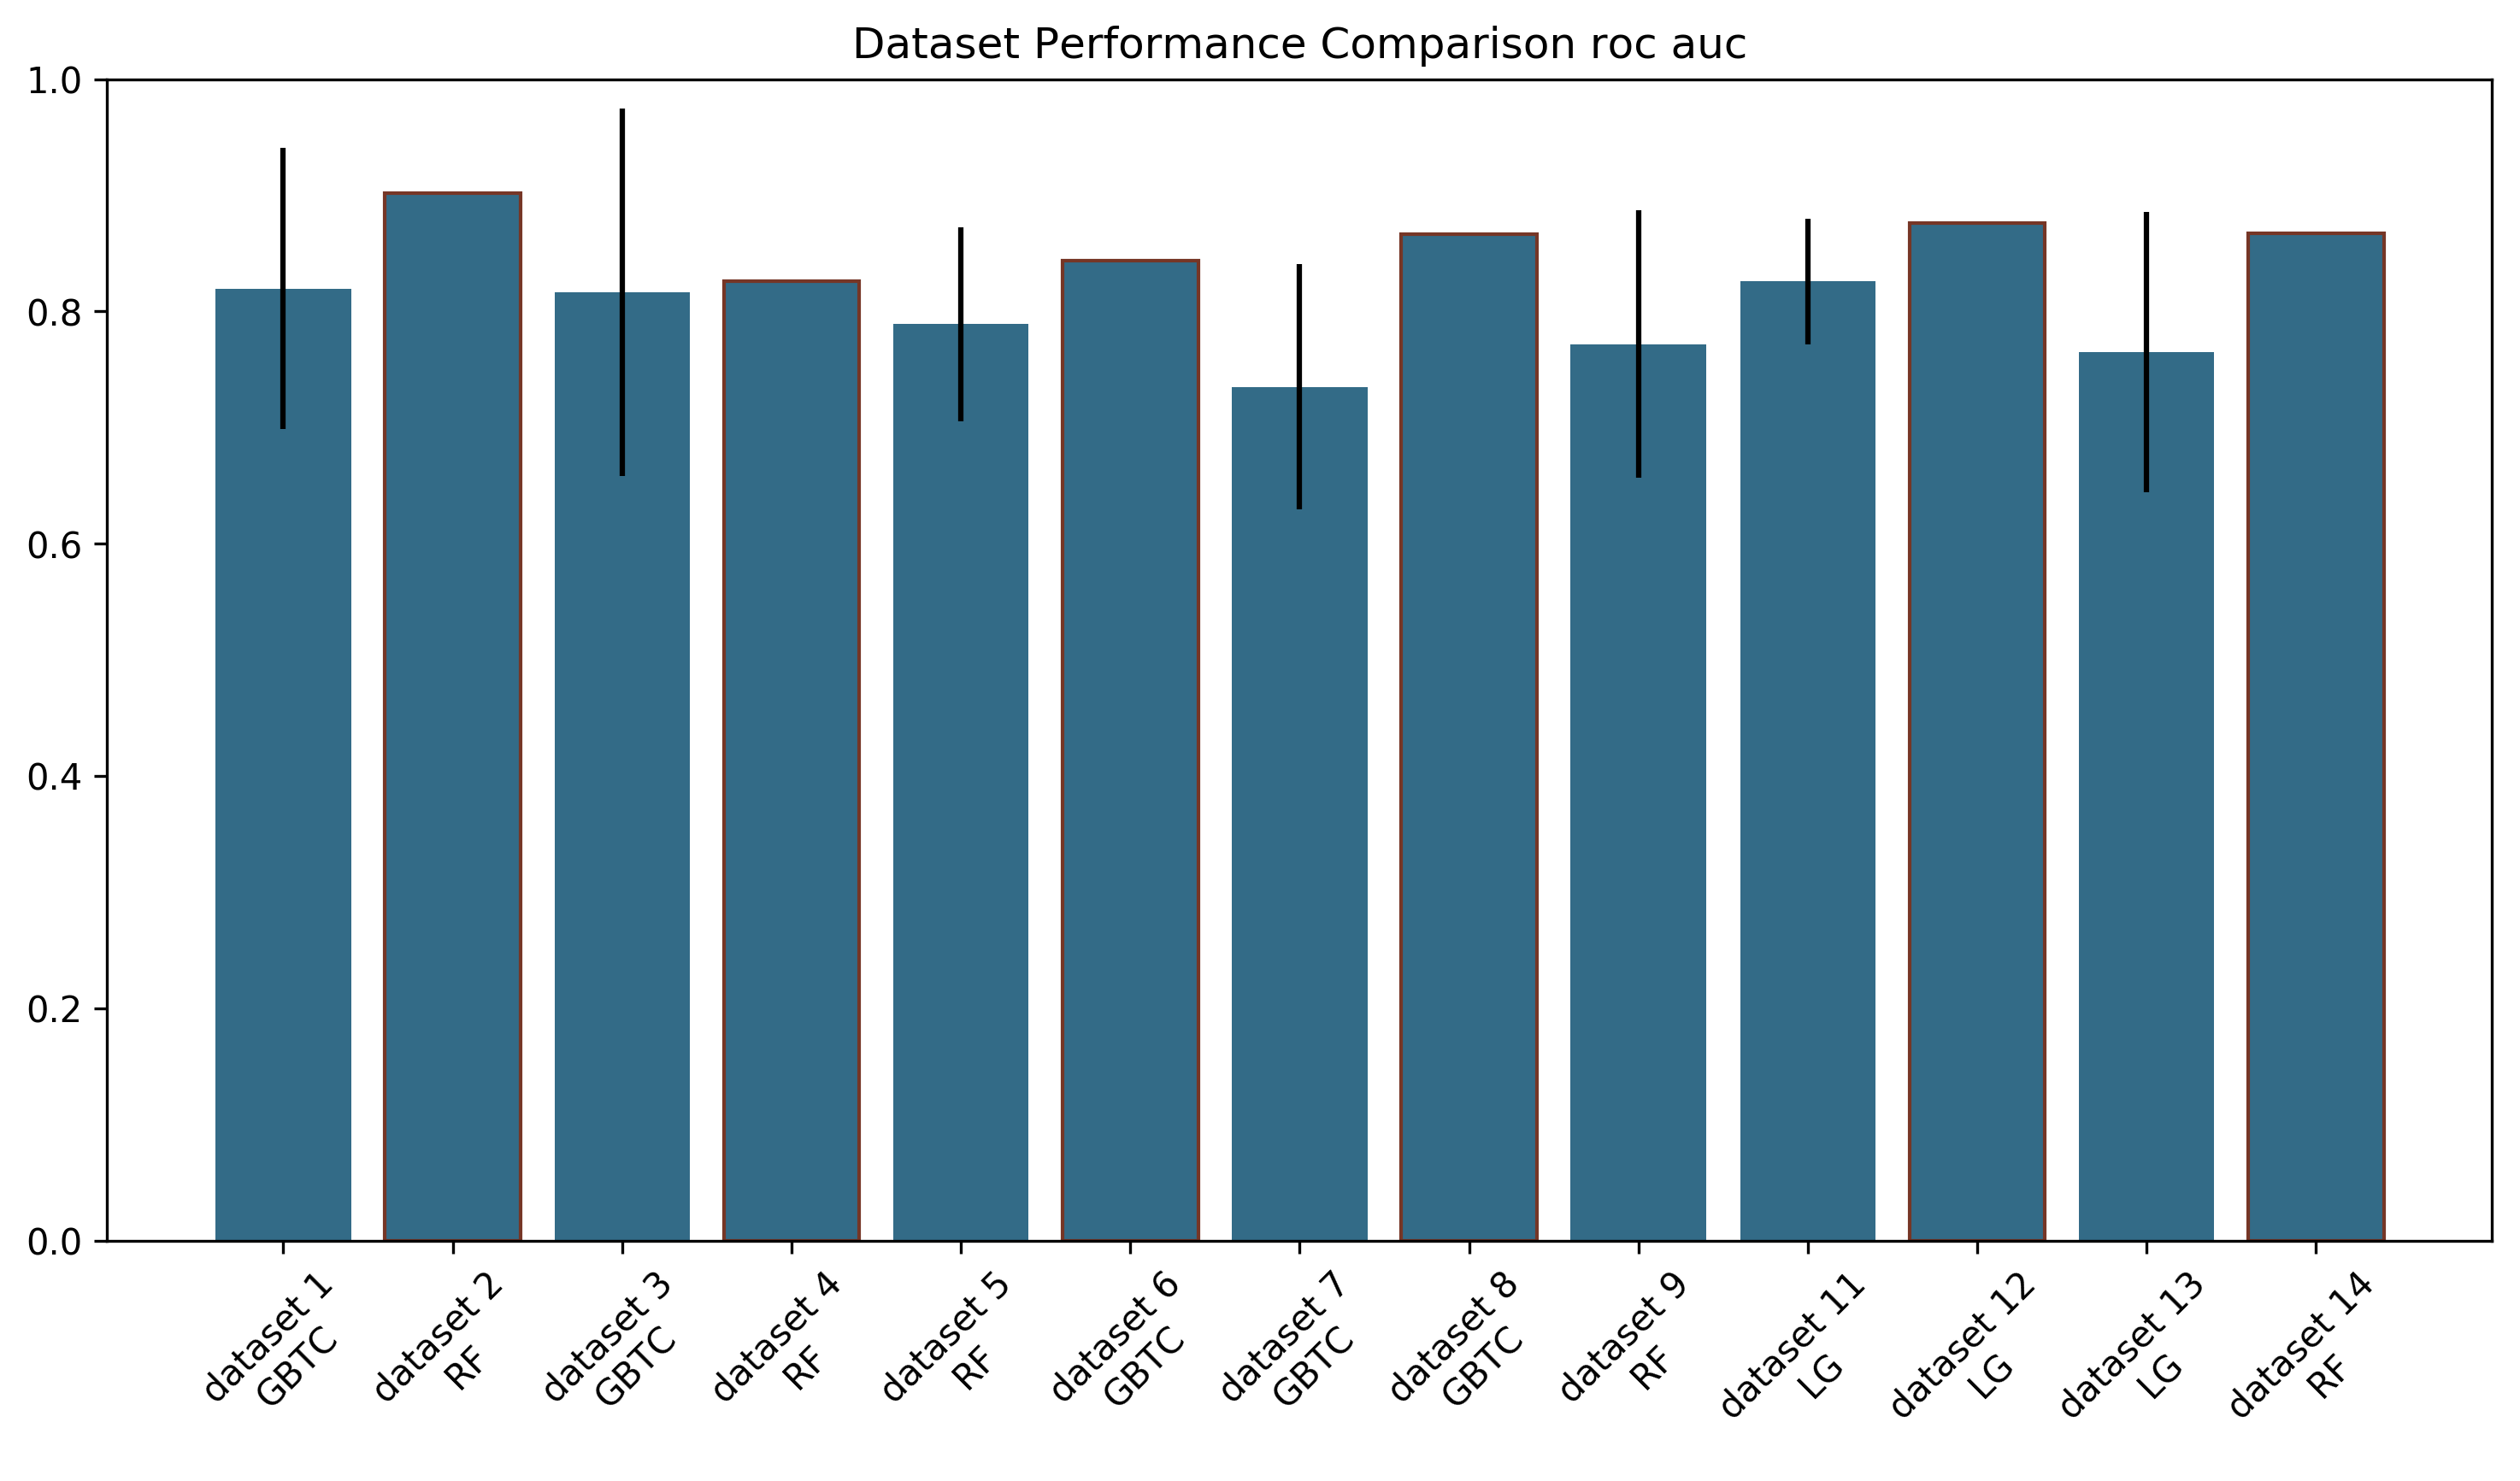

In [4]:
dataSetComparisonList = ["dataset_1_", "dataset_2_", "dataset_3_", "dataset_4_", 
"dataset_5_", "dataset_6_", "dataset_7_", "dataset_8_", 
"dataset_9_", "dataset_10_", "dataset_11_", "dataset_12_", 
"dataset_13_", "dataset_14_", ]
datasetBestModelDict = plotDatasetModelComparison(allDataModelDict = allDataModelDict,
                           dataSetComparisonList = dataSetComparisonList,
                               compMetric = "roc_auc", removeZeroF1Score = True)
pp.pprint(datasetBestModelDict)

Dataset with all zero f1 scores are being removed from plots
{   'dataset_11_': (   'logistic',
                       0.82570170327321579,
                       0.054070431583182747,
                       0.66629538061788907,
                       0.12104868621131465),
    'dataset_12_': (   'logistic',
                       0.87585499316005477,
                       0.0,
                       0.82352941176470584,
                       0.0),
    'dataset_13_': (   'logistic',
                       0.76513169799939684,
                       0.1208257975804005,
                       0.63569002845818234,
                       0.10225950467924015),
    'dataset_14_': (   'randomForest',
                       0.86703296703296706,
                       0.0,
                       0.63414634146341453,
                       1.1102230246251565e-16)}


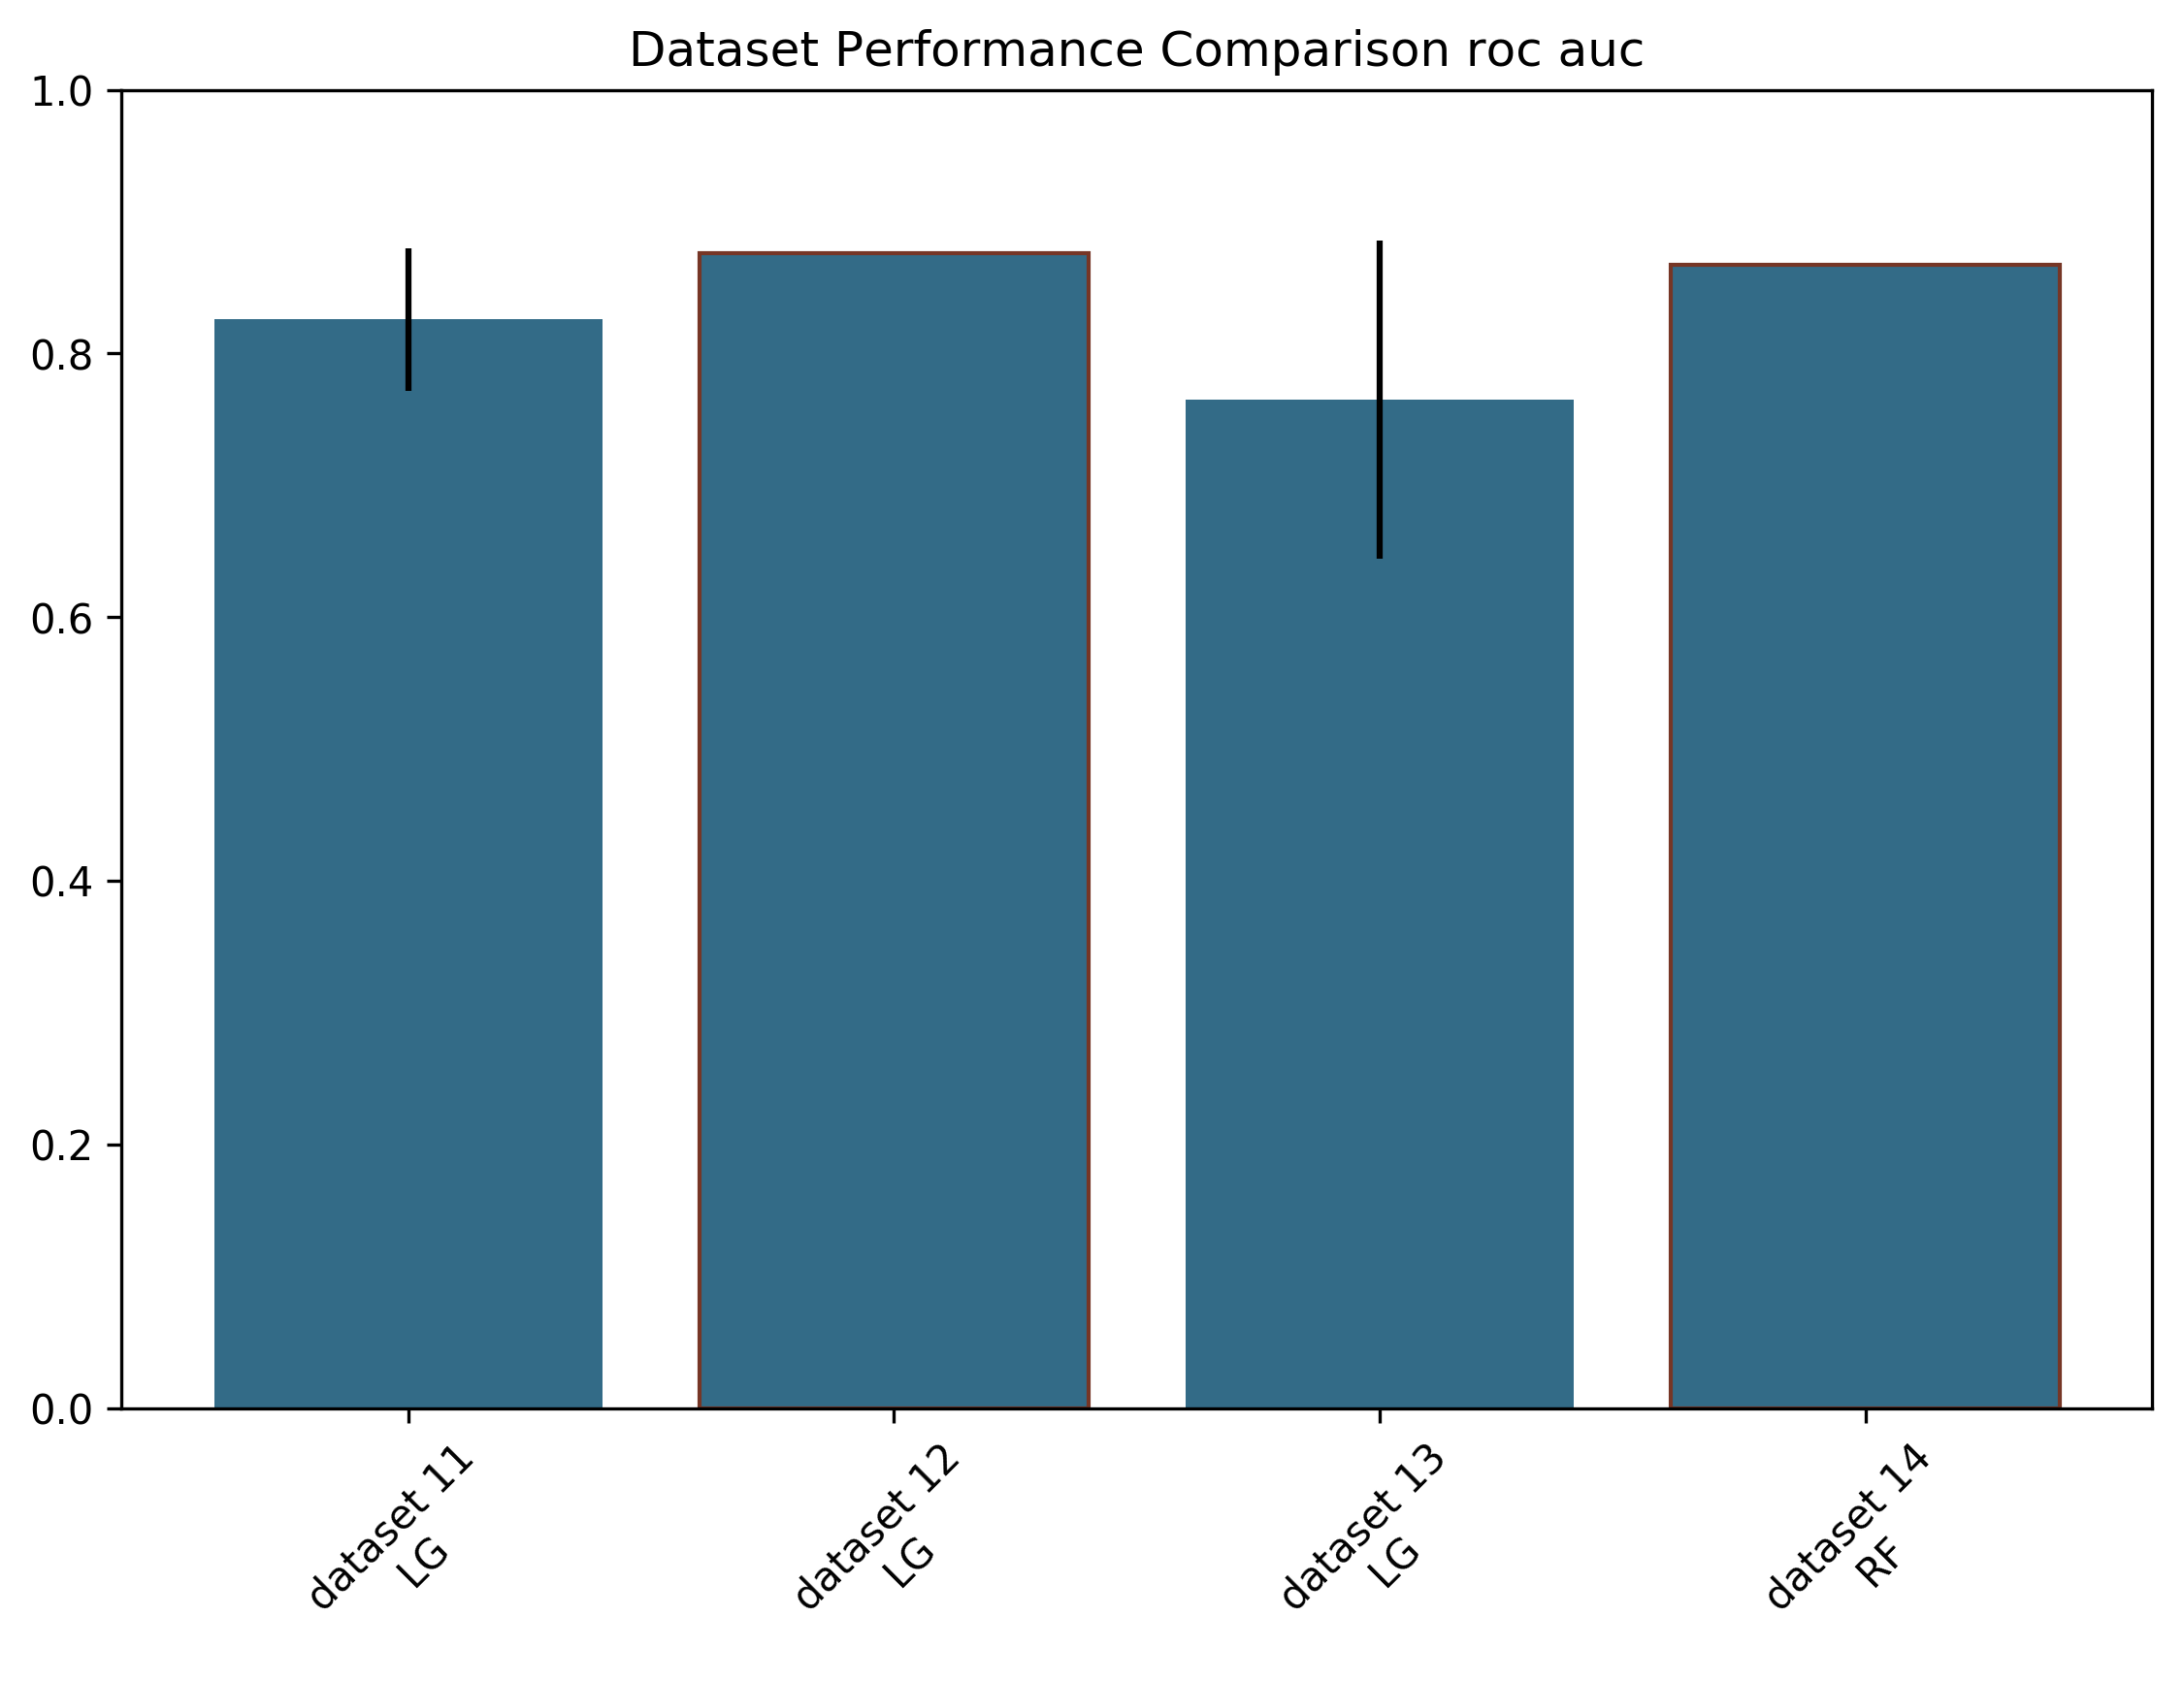

In [5]:
dataSetComparisonList = ["dataset_11_", "dataset_12_", "dataset_13_", "dataset_14_", ]
datasetBestModelDict = plotDatasetModelComparison(allDataModelDict = allDataModelDict,
                           dataSetComparisonList = dataSetComparisonList,
                               compMetric = "roc_auc", removeZeroF1Score = True)
pp.pprint(datasetBestModelDict)

Dataset with all zero f1 scores are being removed from plots
{   'dataset_11_': (   'logistic',
                       0.82570170327321579,
                       0.054070431583182747,
                       0.66629538061788907,
                       0.12104868621131465),
    'dataset_12_': (   'logistic',
                       0.87585499316005477,
                       0.0,
                       0.82352941176470584,
                       0.0)}


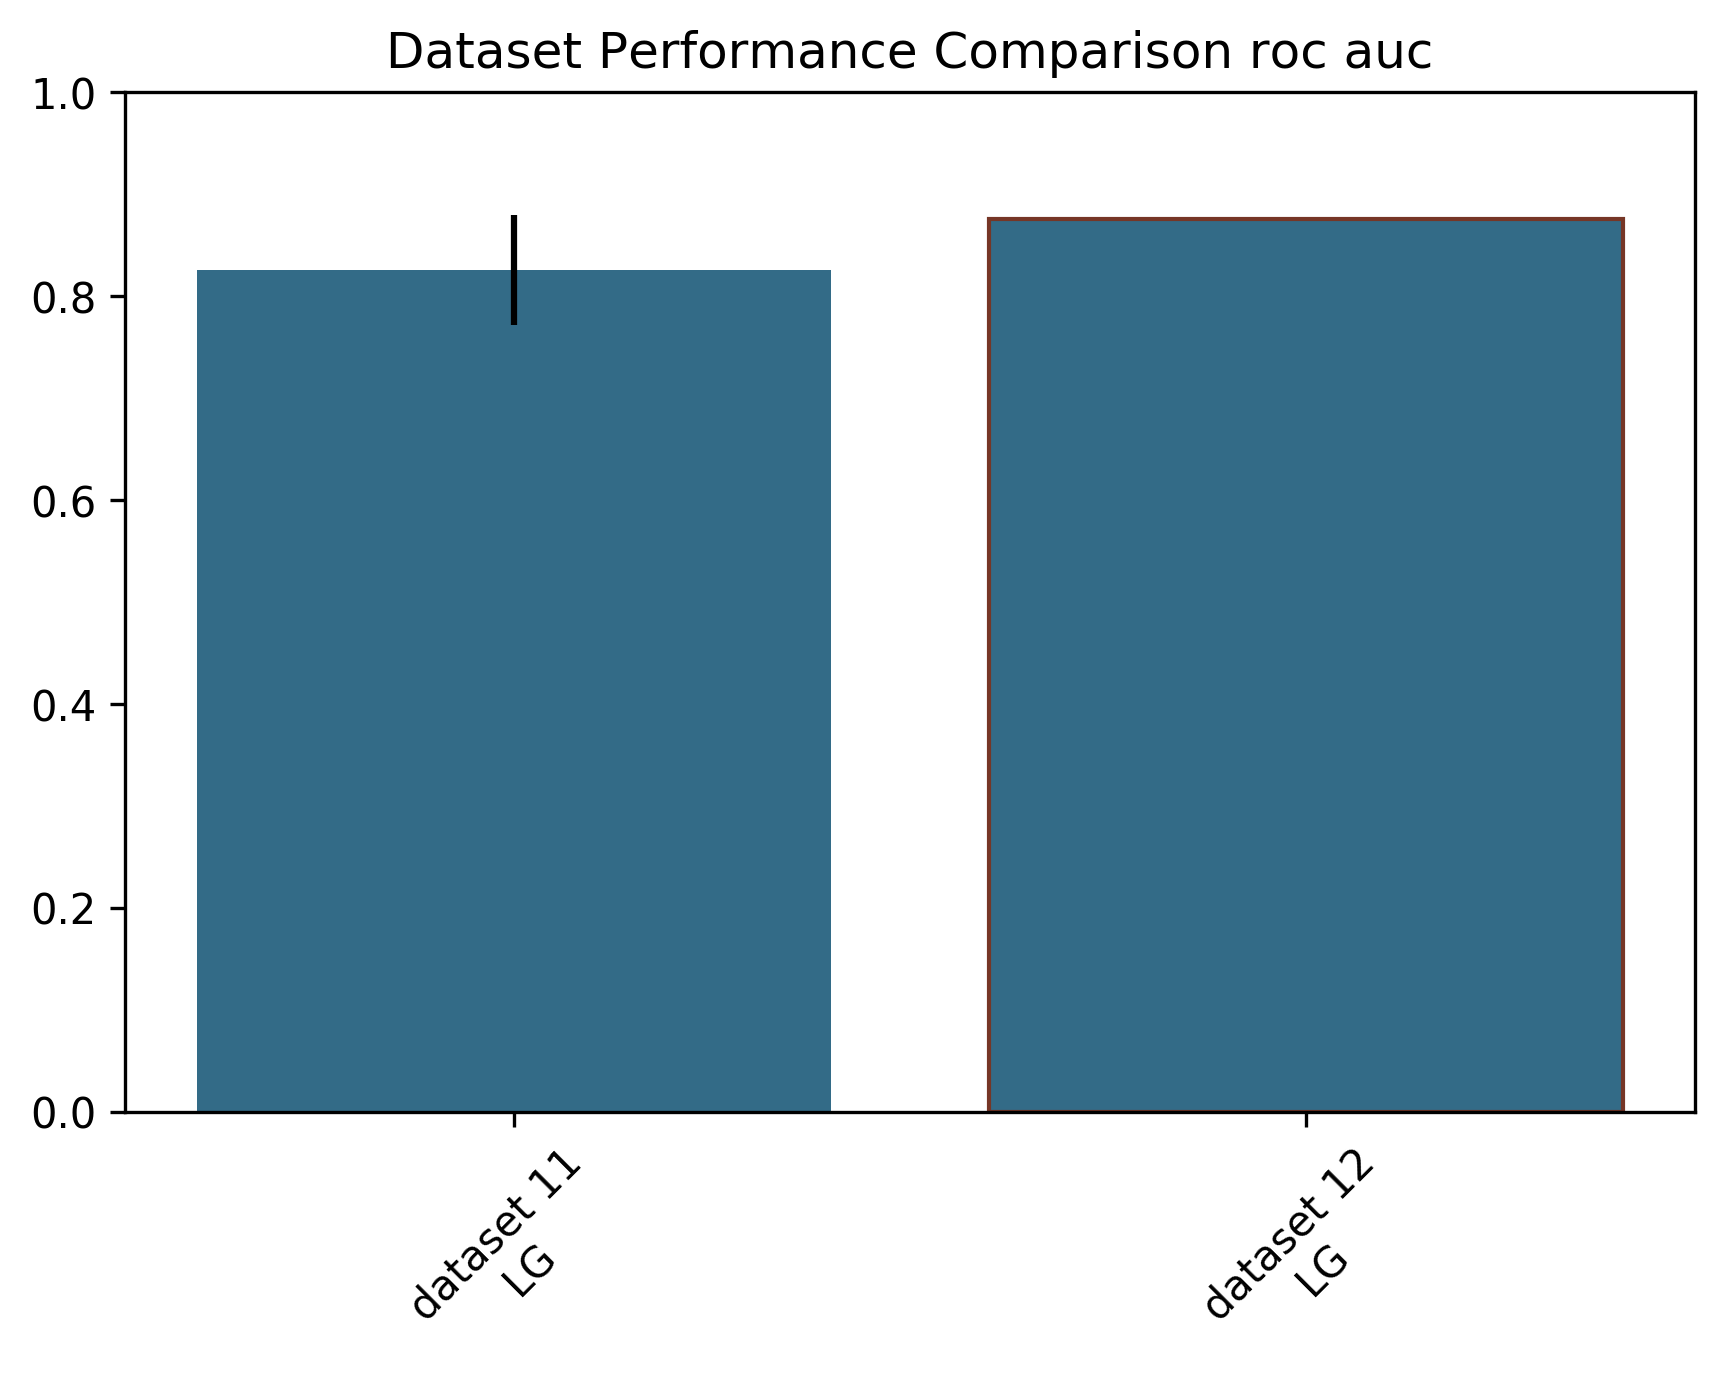

In [6]:
dataSetComparisonList = ["dataset_11_", "dataset_12_"]
datasetBestModelDict = plotDatasetModelComparison(allDataModelDict = allDataModelDict,
                           dataSetComparisonList = dataSetComparisonList,
                               compMetric = "roc_auc", removeZeroF1Score = True)
pp.pprint(datasetBestModelDict)

## Inspecting Dataset 12's best model


In [7]:
from collections import defaultdict
modelName = "logistic"
modelDict = allDataModelDict["dataset_12_"][modelName]
dataPath = "data/MLData/pbr_ml_project_datasets_20180423/dataset_12_train.csv"
# modelDict = modelDictAll["GBTC"]
bestModel = modelDict["gridcv"].best_estimator_
bestModel = modelDict["gridcv"].best_estimator_
featureTransformer = bestModel.steps[0][1]
df = pd.read_csv(dataPath)
df = df.set_index("isolate")
X_df = df.drop(labels = ["pbr_res"], axis = 1)
X = X_df.values
allFeatureNames = np.array(list(X_df))
chosenFeatures = allFeatureNames[[featureTransformer.transform(np.arange(X.shape[1]).reshape([1, X.shape[1]]))]]
chosenFeatures = chosenFeatures[0]


# print(bestModelParams_GBTC.feature_importances_)
bestModelParams = bestModel.get_params()[modelName]
if modelName == "GBTC":
    print("feature importance for GBTC")
#     bestModelParams = bestModel.get_params()[modelName]
#     print("{} features passed to this model".format(len(bestModelParams.feature_importances_))) # for GBTC
#     print("{} features given feature importance above 0\n".format(sum(bestModelParams.feature_importances_ > 0)))
    featureImportance = bestModelParams.feature_importances_
elif modelName == "logistic":
    print("Feature importance logistic")
#     print("{} features passed to this model".format(len(bestModelParams.coef_[0]))) # for ligistic
#     print("{} features given feature importance above 0\n".format(sum(bestModelParams.coef_[0] != 0)))
    featureImportance = bestModelParams.coef_[0]
featureImportance = featureImportance
# importanceOrder = np.argsort(np.abs(featureImportance))[::-1]
# # print(importanceOrder)
# # print(np.argsort(featureImportance)[::-1])
# # print(featureImportance)
# # 1/0
# featureImportance = featureImportance[importanceOrder]

# chosenFeatures = chosenFeatures[importanceOrder]

featureImportanceDict = defaultdict(int) # features and coefficients line up
# but because there can be multiple for logistic regression this needs to be 
# added together.
for feat, imp in zip(chosenFeatures, featureImportance):
    featureImportanceDict[feat] += imp

nNonZeroFeats = 0
for _, imp in featureImportanceDict.items():
    if imp != 0.0:
        nNonZeroFeats += 1
featureImportanceTupleLit = sorted(featureImportanceDict.items(),
                                   key=lambda p:np.abs(p[1]), reverse = True)# sorting list    


print("{} features passed to this model".format(len(chosenFeatures))) # for logistic
print("{} unique features passed to this model".format(len(set(chosenFeatures)))) # for logistic
print("{} features given feature importance above 0\n".format(nNonZeroFeats))

for feature, importanceMeasure in featureImportanceTupleLit:
    if importanceMeasure != 0.0:
        print("Feature {} coefficient/importance {}\n".format(feature, importanceMeasure))


print("featureName,importanceMetric")
for feature, importanceMeasure in featureImportanceTupleLit:
    if importanceMeasure != 0.0:
        print("{},{}".format(feature, importanceMeasure))


Feature importance logistic
129 features passed to this model
128 unique features passed to this model
45 features given feature importance above 0

Feature KP0228_03718 coefficient/importance 4.282781739792756

Feature KP0228_04626 coefficient/importance -3.667042344310688

Feature KP0228_02747 coefficient/importance -3.1799640829018374

Feature mgrB coefficient/importance 3.107171593334924

Feature KP0228_03719 coefficient/importance 2.673367305135039

Feature KP0228_00231 coefficient/importance 2.451140910693596

Feature KP0228_00418 coefficient/importance -1.5549968267551526

Feature KP0228_02559 coefficient/importance 1.4672611568568525

Feature KP0228_04079 coefficient/importance 1.1885067001775578

Feature KP0228_01560 coefficient/importance -1.1472328954086957

Feature KP0228_03951 coefficient/importance -0.9735850413524861

Feature KP0228_05251 coefficient/importance 0.9168064507352621

Feature KP0228_00532 coefficient/importance 0.9160378967598227

Feature KP0228_04662 coeffi

## Get confusion matrices
Right now models are refit on the entire dataset so you need to handle that 

In [10]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix
import copy
valDF = pd.read_csv("data/MLData/pbr_ml_project_datasets_20180423/dataset_12_test.csv")
valDF = valDF.set_index("isolate")
X_df = valDF.drop(labels = ["pbr_res"], axis = 1)
X_val = X_df.values
Y_df = valDF["pbr_res"]
Y_val = Y_df.values 

trainDF = pd.read_csv("data/MLData/pbr_ml_project_datasets_20180423/dataset_12_train.csv")
trainDF = trainDF.set_index("isolate")
X_df = trainDF.drop(labels = ["pbr_res"], axis = 1)
X_train = X_df.values
Y_df = trainDF["pbr_res"]
Y_train = Y_df.values 

bestEstimatorRefit = copy.deepcopy(modelDict["gridcv"].best_estimator_)
bestEstimatorRefit.fit(X_train, Y_train)
preds = bestEstimatorRefit.predict(X_val)
scores = bestEstimatorRefit.predict_proba(X_val)
rocauc = roc_auc_score(y_true = Y_val, y_score = scores[:,1])
f1 = f1_score(y_true = Y_val, y_pred = preds)
prec = precision_score(y_true = Y_val, y_pred = preds)
rec = recall_score(y_true = Y_val, y_pred = preds)
print("rocauc: {}".format(rocauc))
print("f1: {}".format(f1))
print("prec: {}".format(prec))
print("rec: {}".format(rec))
print("confusion matrix. tuth by prediction")
print(confusion_matrix(y_true = Y_val, y_pred = preds))
# truth by prediction

rocauc: 0.8758549931600548
f1: 0.8235294117647058
prec: 0.8235294117647058
rec: 0.8235294117647058
confusion matrix. tuth by prediction
[[37  6]
 [ 6 28]]


## AUROC for models fit using a held out set

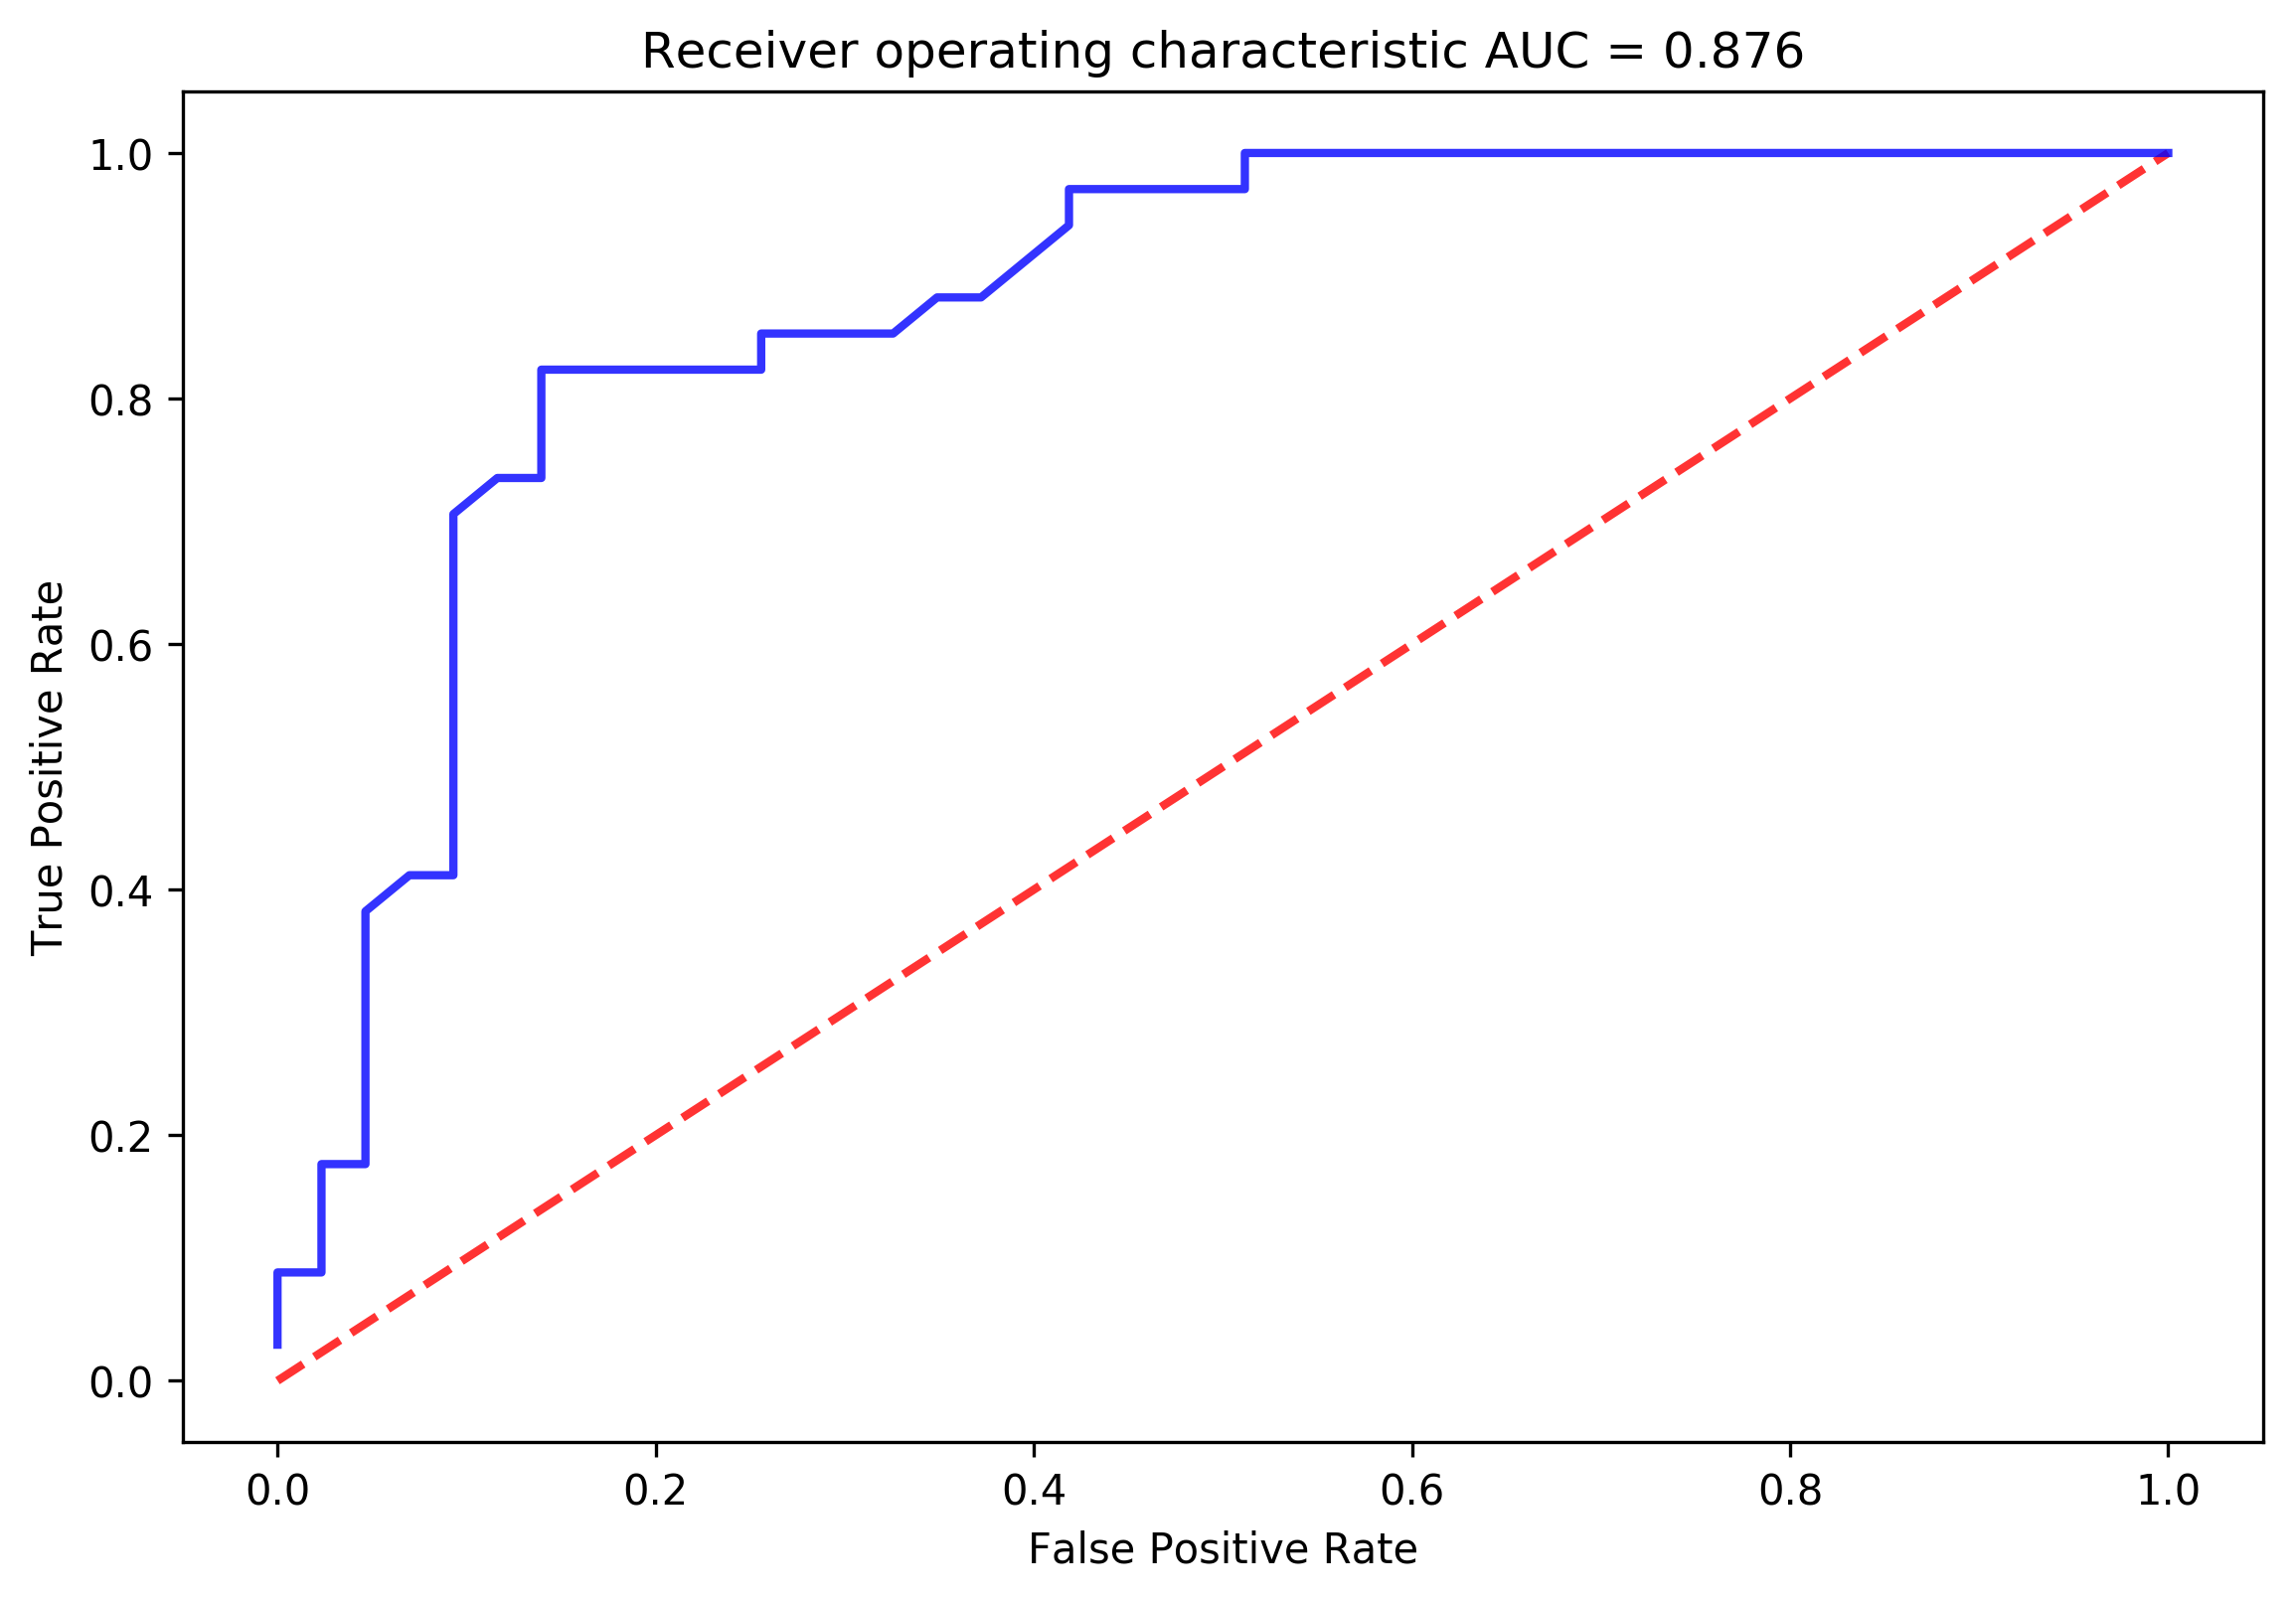

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
cv = StratifiedKFold(n_splits=6)
# classifier = svm.SVC(kernel='linear', probability=True,
#                      random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
fig=plt.figure(figsize=(9, 6), dpi= 300, facecolor='w', edgecolor='k')
probas_ = bestEstimatorRefit.fit(X_train, Y_train).predict_proba(X_val)
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_val, probas_[:, 1])
auc = roc_auc_score(Y_val, probas_[:, 1])
auc = np.round(auc, decimals = 3)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Random Guess', alpha=.8)

plt.plot(fpr, tpr, color='b',
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic AUC = {}'.format(auc))
fig.savefig("plots/AUC_bestModel_holdOut.png")


In [12]:
trainDF = pd.read_csv("data/MLData/pbr_ml_project_datasets_20180423/dataset_12_train.csv")
# print(trainDF.shape)
valDF = pd.read_csv("data/MLData/pbr_ml_project_datasets_20180423/dataset_12_test.csv")
# print(valDF.shape)
allData = pd.concat([trainDF, valDF])

# df = pd.read_csv("data/MLData/pbr_ml_project_datasets_20180423/dataset_12_train.csv")
allData = allData.set_index("isolate")
X_df = allData.drop(labels = ["pbr_res"], axis = 1)
X = X_df.values
Y_df = allData["pbr_res"]
Y = Y_df.values

## AUROC for models fit using 10-fold CV

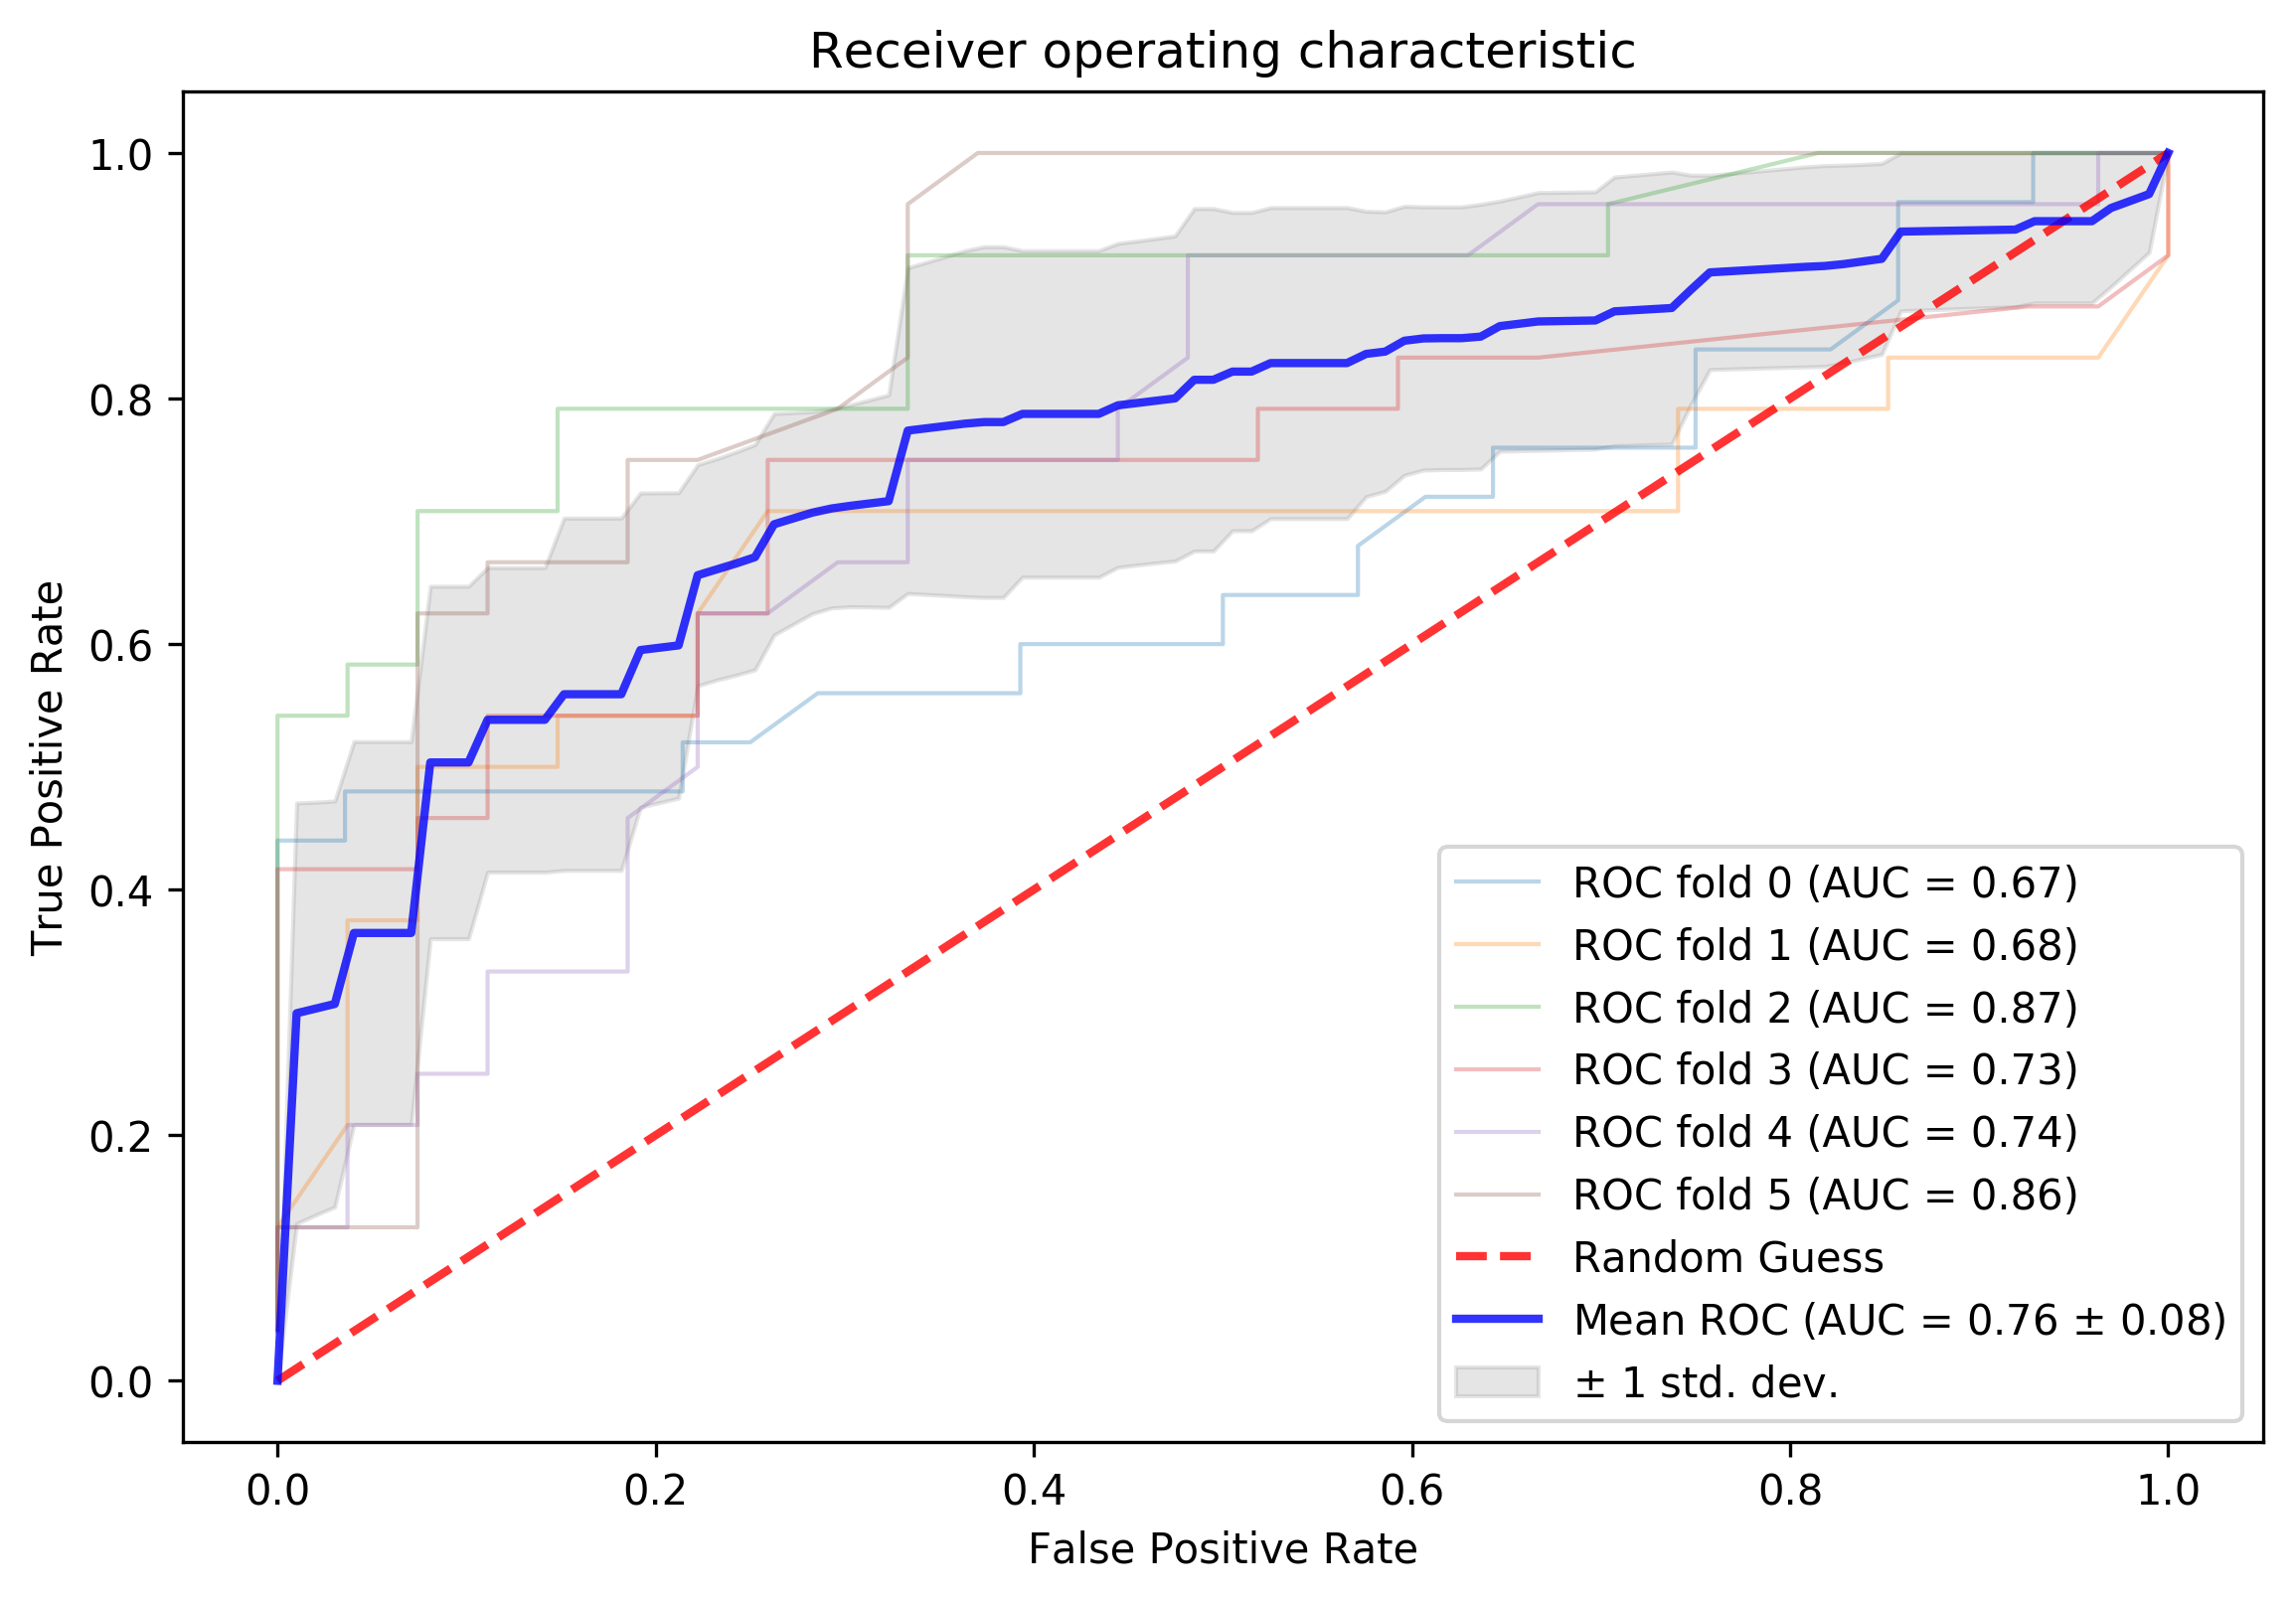

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
cv = StratifiedKFold(n_splits=6)
# classifier = svm.SVC(kernel='linear', probability=True,
#                      random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
fig=plt.figure(figsize=(9, 6), dpi= 300, facecolor='w', edgecolor='k')
for train, test in cv.split(X, Y):
    probas_ = bestEstimatorRefit.fit(X[train], Y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Random Guess', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.show()
fig.savefig("plots/AUC_bestModel_CV.png")

f1
[ 0.758  0.824  0.776  0.765]
[ 0.  0.  0.  0.]
recall
[ 0.735  0.824  0.765  0.765]
[ 0.  0.  0.  0.]
precision
[ 0.781  0.824  0.788  0.765]
[ 0.  0.  0.  0.]


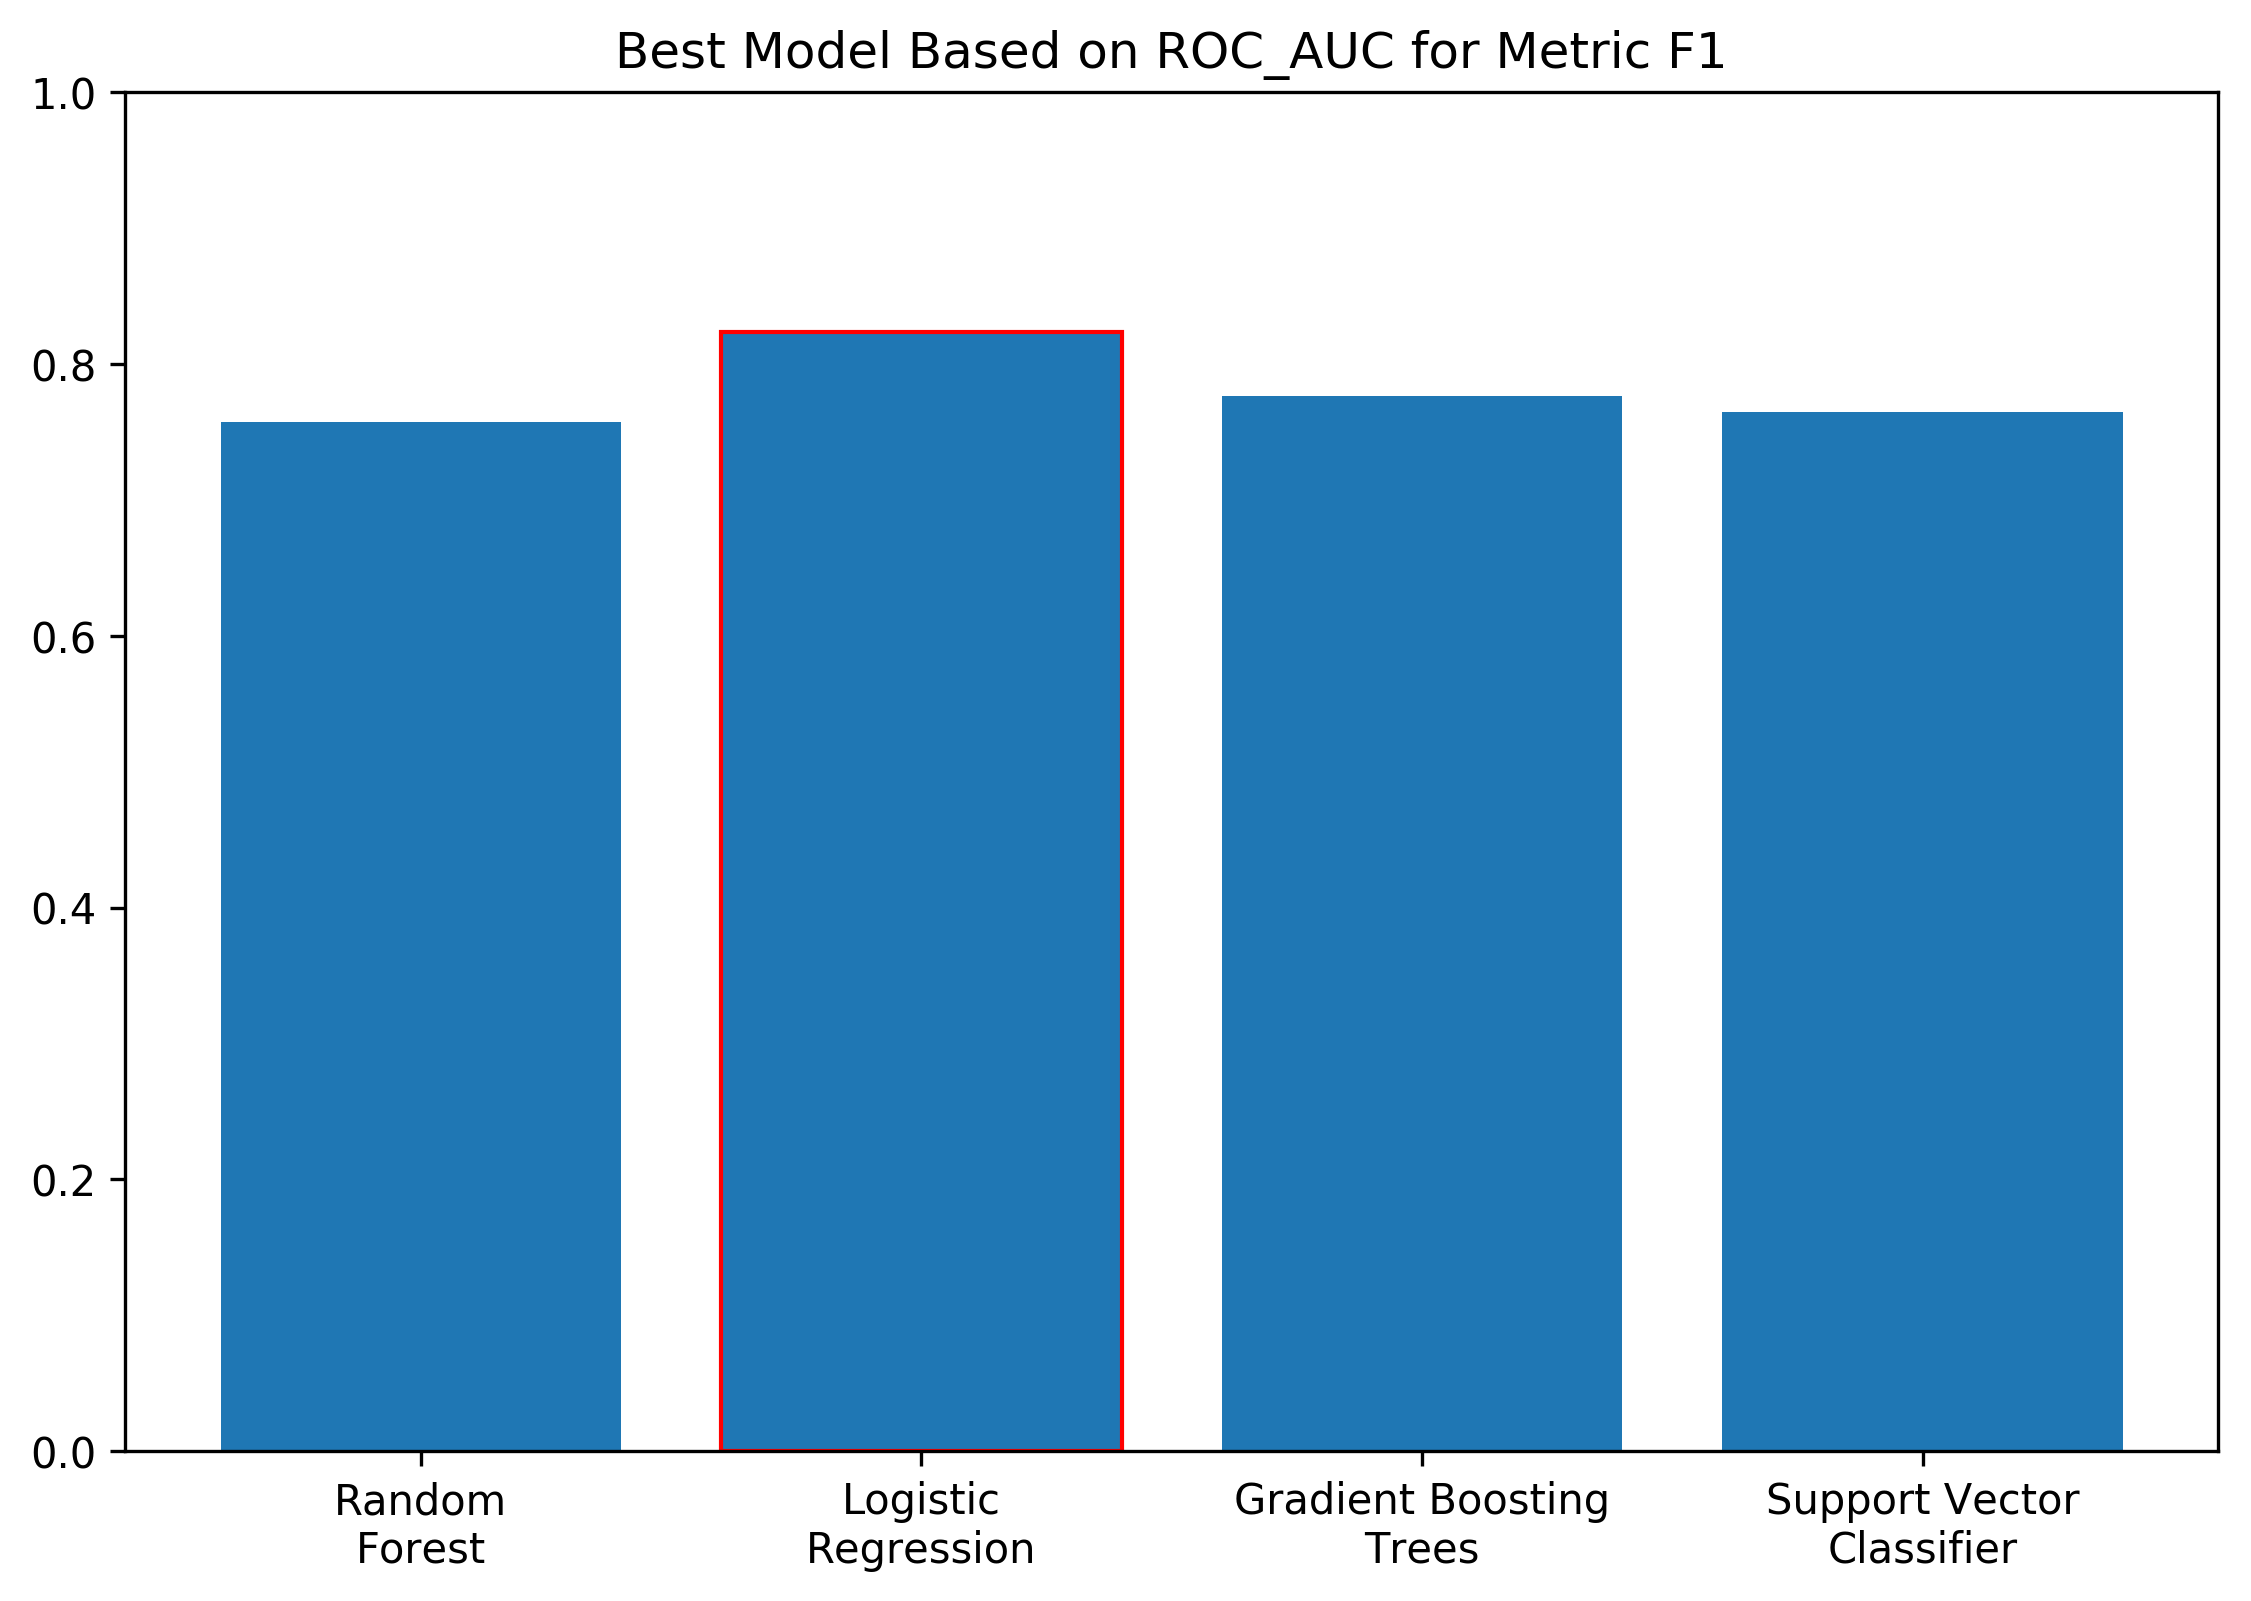

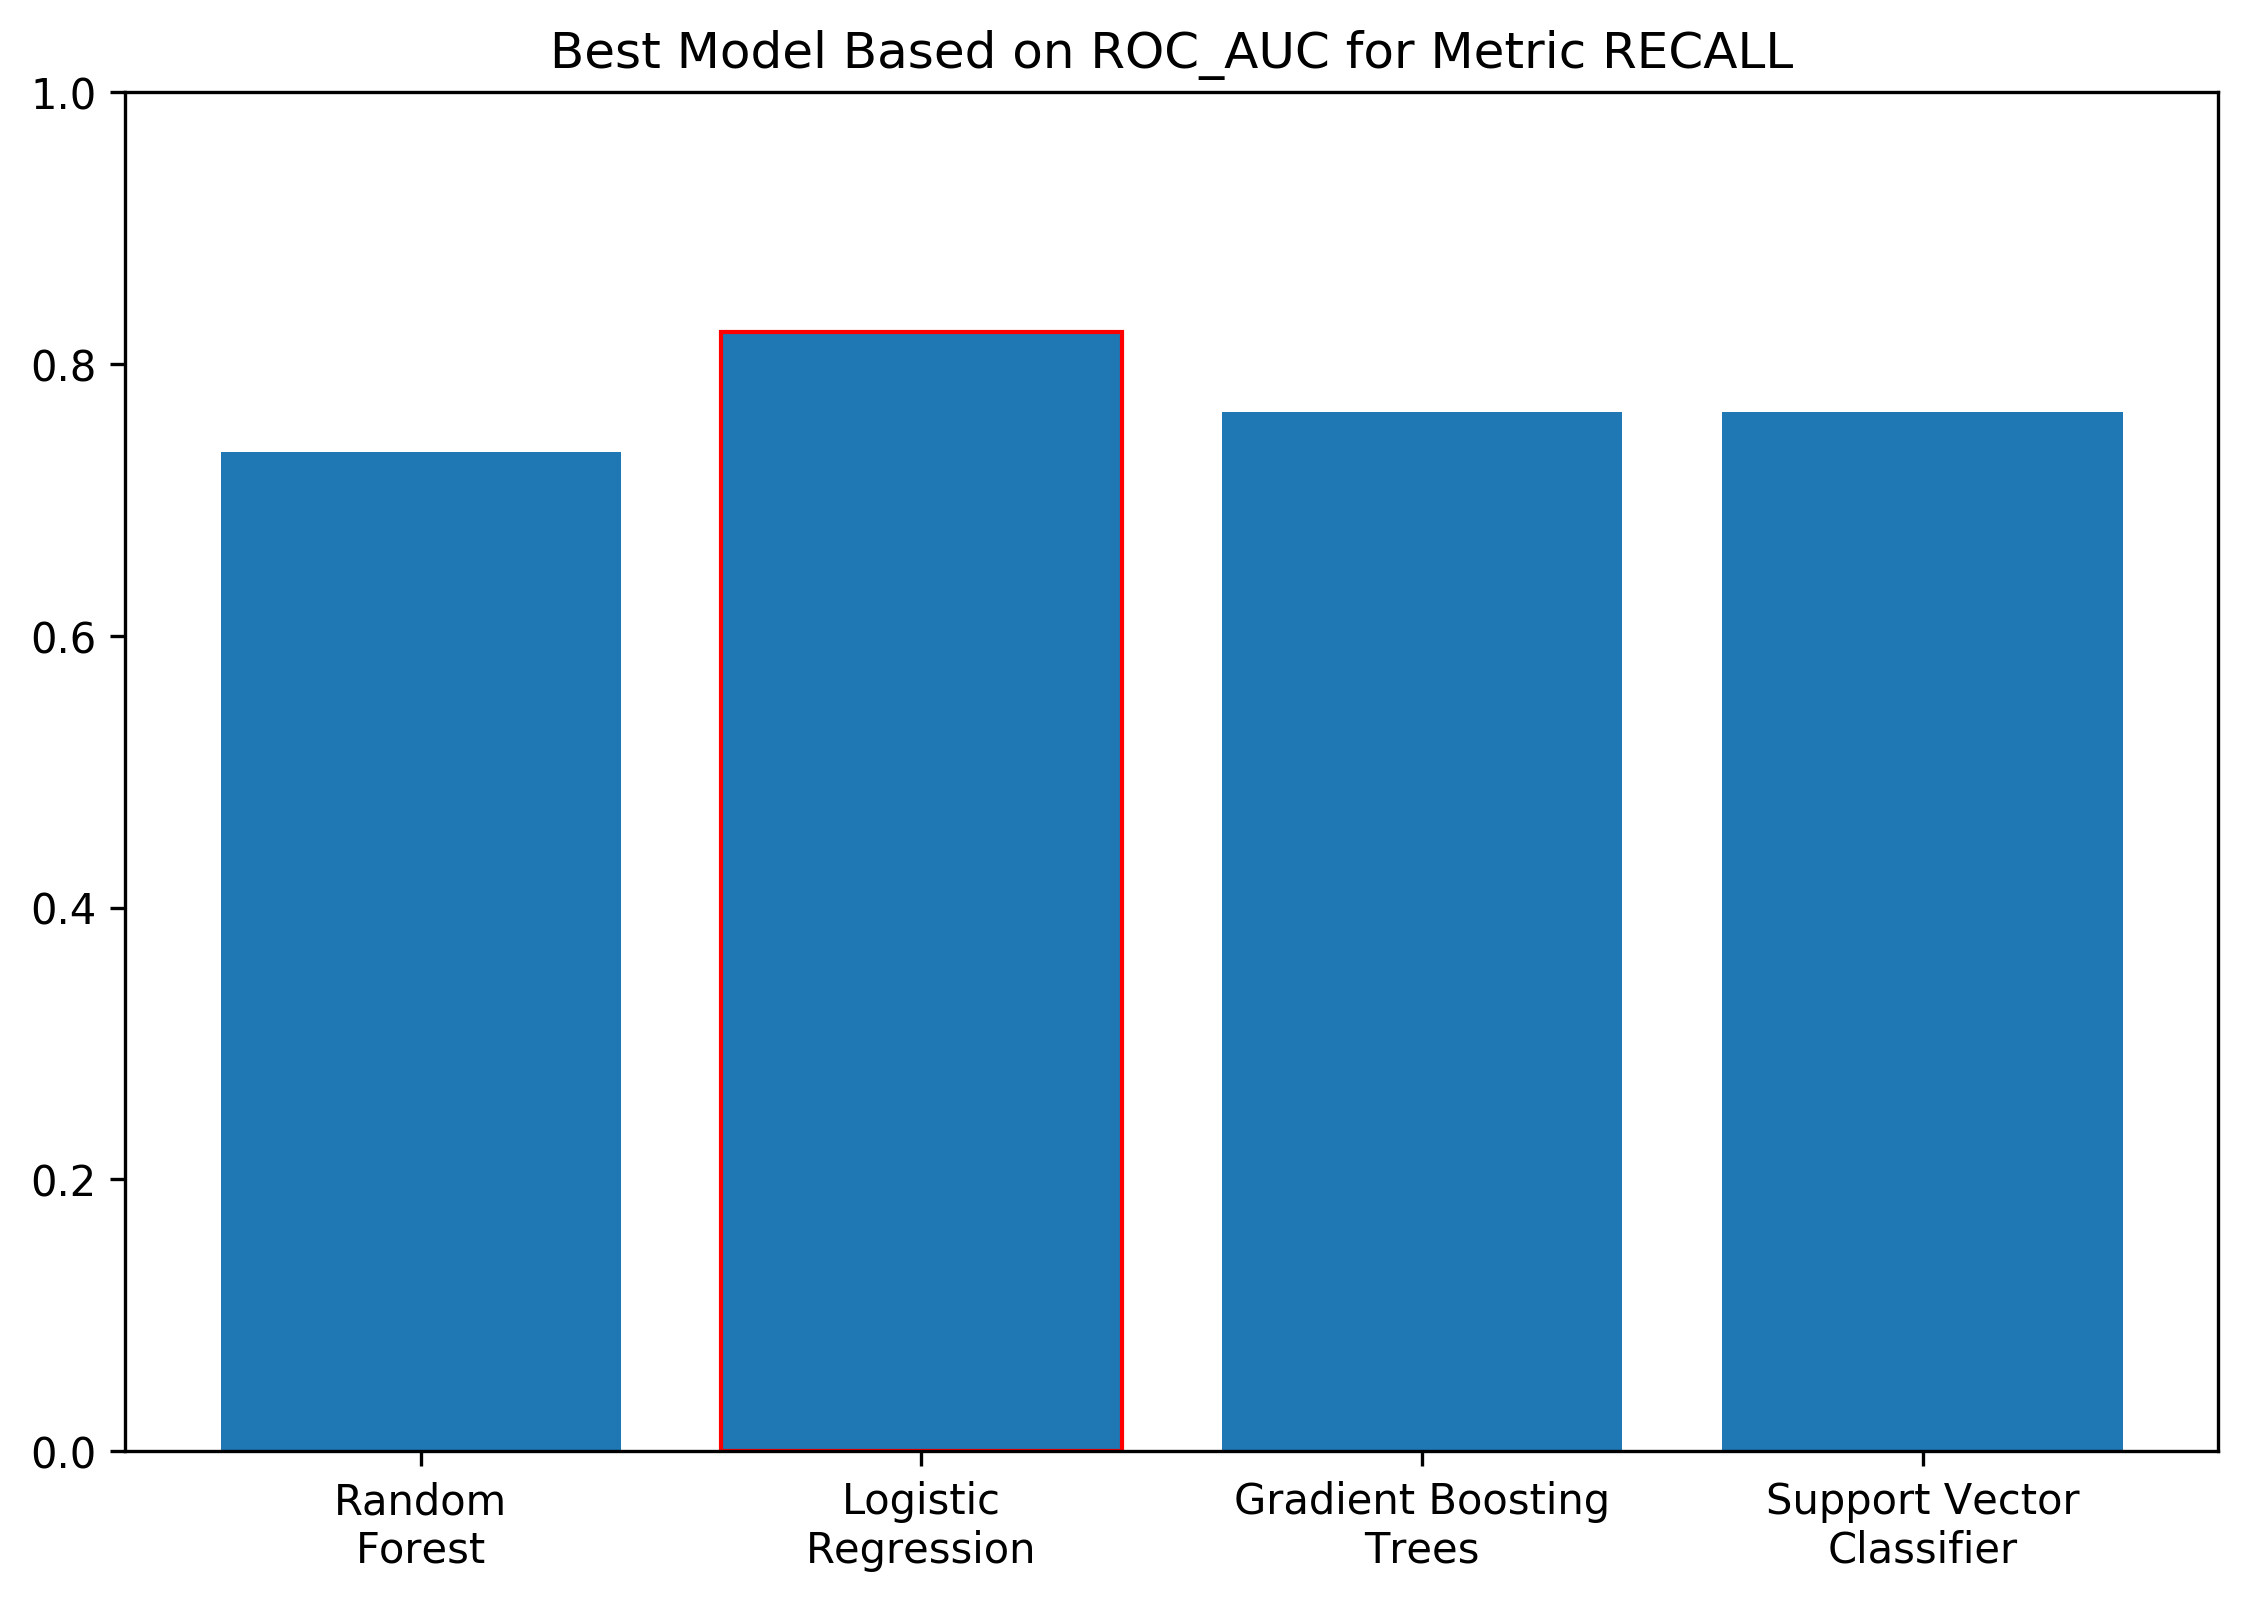

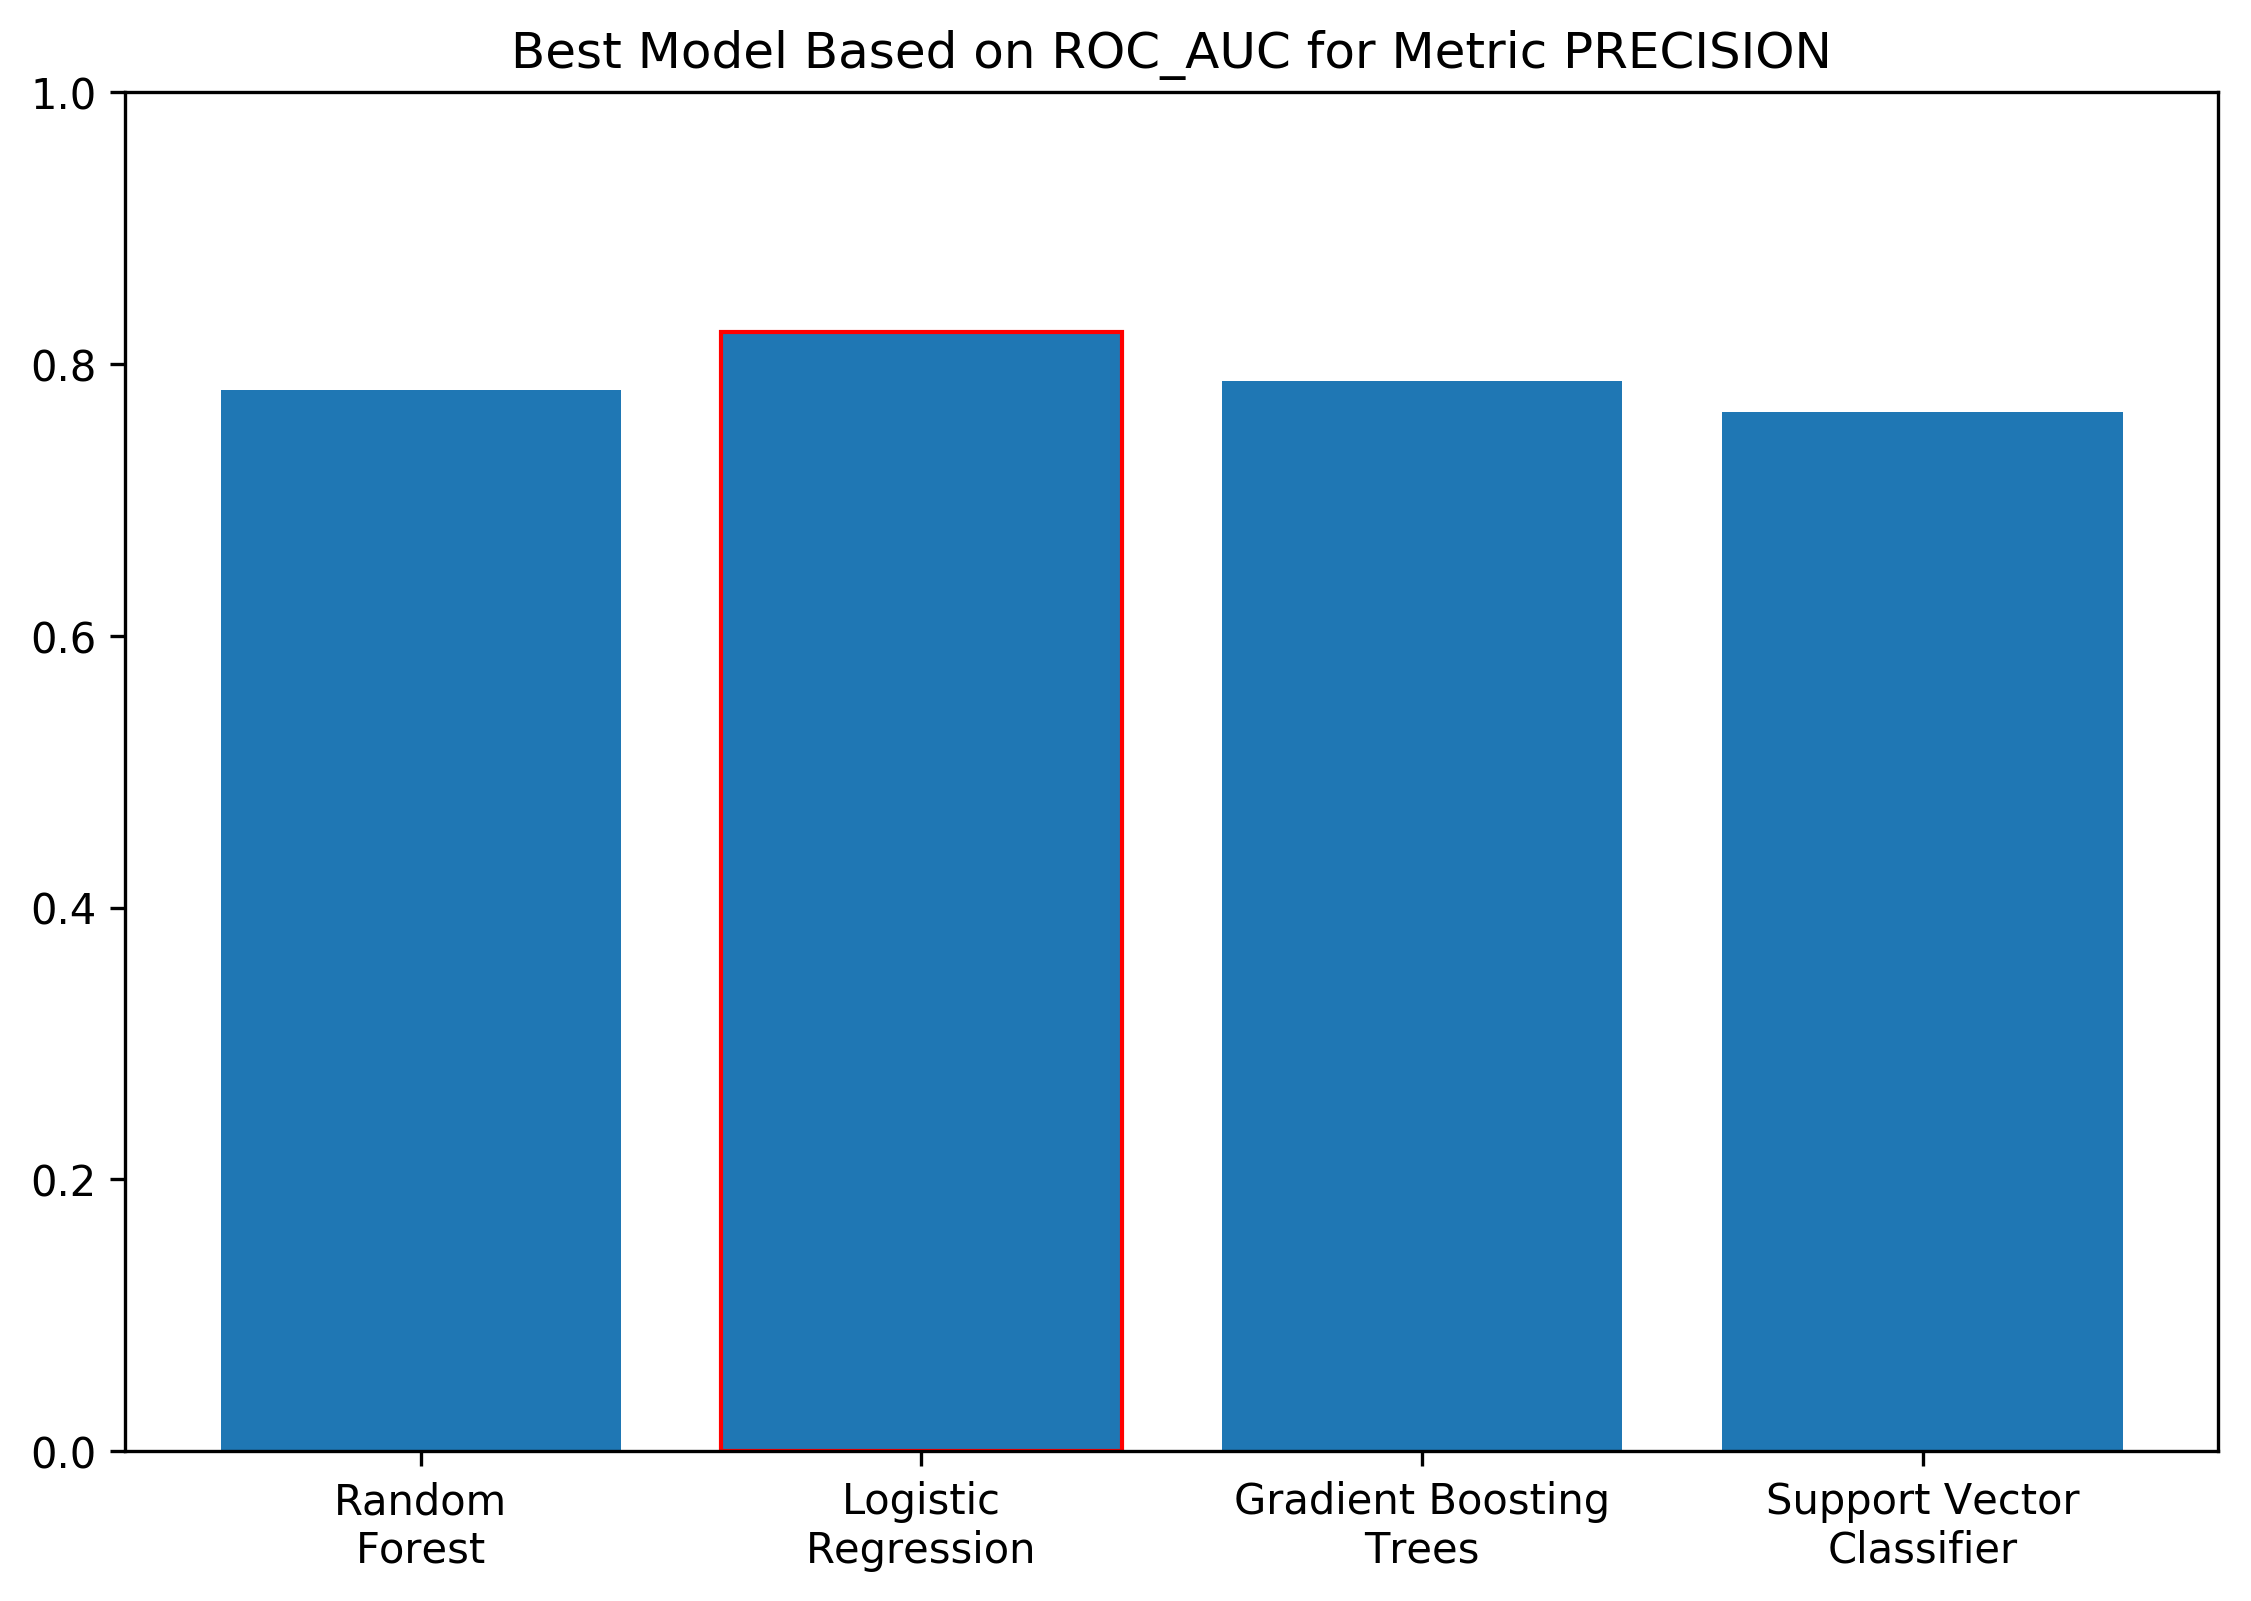

In [13]:
scoringDict = plotBestModelComparison(allDataModelDict['dataset_12_'])

In [5]:
scoringDict

defaultdict(<function src.mlPipeline.plotting.plotBestModelComparison.<locals>.<lambda>>,
            {'GBTC': defaultdict(float,
                         {'f1_mean': 0.77611940298507454,
                          'f1_std': 0.0,
                          'precision_mean': 0.78787878787878785,
                          'precision_std': 0.0,
                          'recall_mean': 0.76470588235294112,
                          'recall_std': 0.0}),
             'SVC': defaultdict(float,
                         {'f1_mean': 0.76470588235294124,
                          'f1_std': 0.0,
                          'precision_mean': 0.76470588235294112,
                          'precision_std': 0.0,
                          'recall_mean': 0.76470588235294112,
                          'recall_std': 0.0}),
             'logistic': defaultdict(float,
                         {'f1_mean': 0.82352941176470584,
                          'f1_std': 0.0,
                          'precision_mean': 0.

# Permutation Test
After the best model has been chosen we need to see if our model is truly picking up on signal. To do this we can permute the labels, and re-estimate the CV error for the best model's parameters.

In [23]:
from time import time
start = time()

In [24]:
Y.mean()

0.4707792207792208

## Permutation test done with CV

In [96]:
from sklearn.model_selection import cross_val_score
from time import time
nRepeats = 500
modelDict = allDataModelDict['dataset_12_']['logistic']
bestModel = modelDict["gridcv"].best_estimator_
scoringMetric = modelDict["refitMetric"]
df = pd.read_csv(dataPath)
df = df.set_index("isolate")
X_df = df.drop(labels = ["pbr_res"], axis = 1)
X = X_df.values
Y_df = df["pbr_res"]
Y_shuffle = np.array(Y_df.values)
Y = np.array(Y_df.values)
allScoresMeanCV_shuffle = np.full(shape = nRepeats, fill_value = -1,
                                  dtype = float)
allScoresStdCV_shuffle = np.full(shape = nRepeats, fill_value = -1,
                                 dtype = float)
allScoresMeanCV_true = np.full(shape = nRepeats, fill_value = -1,
                               dtype = float)
allScoresStdCV_true = np.full(shape = nRepeats, fill_value = -1,
                              dtype = float)

# YShuffle = np.random.shuffle(Y)
shuffledIdx = np.arange(Y.shape[0])


n_cv = 10

start = time()
for i in range(nRepeats):
    np.random.shuffle(shuffledIdx)
#     print(i)
    if np.mod(i, 10) == 0:
        iterTime = time() - start
        print("Running iteration {} in {} seconds".format(i, iterTime))
        start = time()
    np.random.shuffle(Y_shuffle)
    currScoresCV_shuffle = cross_val_score(estimator = bestModel, X = X, y = Y_shuffle,
                                           cv = n_cv, n_jobs = 3, verbose = 0, 
                                           scoring = scoringMetric)
    X = X[shuffledIdx, :]
    Y = Y[shuffledIdx]
    currScoresCV_true = cross_val_score(estimator = bestModel, X = X, y = Y,
                                           cv = n_cv, n_jobs = 3, verbose = 0, 
                                           scoring = scoringMetric)
    allScoresMeanCV_shuffle[i] = currScoresCV_shuffle.mean()
    allScoresStdCV_shuffle[i] = np.std(currScoresCV_shuffle)
    allScoresMeanCV_true[i] = currScoresCV_true.mean()
    allScoresStdCV_true[i] = np.std(currScoresCV_true)
#     print(allScoresMeanCV_shuffle)
#     print(allScoresMeanCV_true)
    

# take in best model
# take in data
# take in n for permutations
# take in optional test set
# take in cv if not test set.
from scipy.stats import ttest_ind
ttest_ind(a = allScoresMeanCV_shuffle,
          b = allScoresMeanCV_true)

Running iteration 0 in 0.0004374980926513672 seconds
Running iteration 10 in 142.70513892173767 seconds
Running iteration 20 in 140.95882320404053 seconds
Running iteration 30 in 142.8495650291443 seconds
Running iteration 40 in 143.63306164741516 seconds
Running iteration 50 in 149.58917498588562 seconds
Running iteration 60 in 143.65398240089417 seconds
Running iteration 70 in 145.91169714927673 seconds
Running iteration 80 in 142.4729940891266 seconds
Running iteration 90 in 139.5033118724823 seconds
Running iteration 100 in 142.23135137557983 seconds
Running iteration 110 in 141.36219310760498 seconds
Running iteration 120 in 142.11380338668823 seconds
Running iteration 130 in 141.0321683883667 seconds
Running iteration 140 in 141.4959008693695 seconds
Running iteration 150 in 145.7419421672821 seconds
Running iteration 160 in 143.68236231803894 seconds
Running iteration 170 in 141.1173813343048 seconds
Running iteration 180 in 141.3674533367157 seconds
Running iteration 190 in 137

Ttest_indResult(statistic=-81.82435501231497, pvalue=0.0)

## Permutation test done with heldout dataset

In [6]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix
trainPath = "data/MLData/pbr_ml_project_datasets_20180423/dataset_12_train.csv"
valPath = "data/MLData/pbr_ml_project_datasets_20180423/dataset_12_test.csv"

print("Using trainFile: {}\nvalFile: {}".format(trainPath, valPath))
trainDF = pd.read_csv(trainPath)
print(trainDF.shape)
valDF = pd.read_csv(valPath)
print(valDF.shape)


valDF = valDF.set_index("isolate")
X_df = valDF.drop(labels = ["pbr_res"], axis = 1)
X_val = X_df.values
Y_df = valDF["pbr_res"]
Y_val = Y_df.values 

trainDF = trainDF.set_index("isolate")
X_df = trainDF.drop(labels = ["pbr_res"], axis = 1)
X_train = X_df.values
Y_df = trainDF["pbr_res"]
Y_train = Y_df.values 
Y_train_shuffle = np.array(Y_df.values)

Using trainFile: data/MLData/pbr_ml_project _datasets_20180423/dataset_12_train.csv
valFile: data/MLData/pbr_ml_project _datasets_20180423/dataset_12_test.csv
(231, 2231)
(77, 2231)


In [7]:
modelName = "logistic"
modelDict = allDataModelDict["dataset_12_"][modelName]
bestModel = copy.deepcopy(modelDict["gridcv"].best_estimator_)

In [8]:
from sklearn.model_selection import cross_val_score
from time import time


def getMetrics(probs, preds, y):
    rocauc = roc_auc_score(y_true = y, y_score = probs)
    f1 = f1_score(y_true = y, y_pred = preds)
    prec = precision_score(y_true = y, y_pred = preds)
    rec = recall_score(y_true = y, y_pred = preds)
    return(rocauc, f1, prec, rec)
    print("rocauc: {}".format(rocauc))
    print("f1: {}".format(f1))
    print("prec: {}".format(prec))
    print("rec: {}".format(rec))
    print("confuysion matrix. rtuth by prediction")


nRepeats = 500
scoringMetric = modelDict["refitMetric"]

allF1_shuffle = np.full(shape = nRepeats, fill_value = -1,
                                  dtype = float)
allF1_true = np.full(shape = nRepeats, fill_value = -1,
                                 dtype = float)
allAUC_shuffle = np.full(shape = nRepeats, fill_value = -1,
                               dtype = float)
allAUC_true = np.full(shape = nRepeats, fill_value = -1,
                              dtype = float)

# YShuffle = np.random.shuffle(Y)
originalSampleIndex = np.arange(Y_train.shape[0])
trainingSampleSize = 200

# n_cv = 10

start = time()
for i in range(nRepeats):
    sampleIndex = np.random.choice(originalSampleIndex,
                                   size = trainingSampleSize,
                                   replace = False)
#     print(i)
    if np.mod(i, 10) == 0:
        iterTime = time() - start
        print("Running iteration {} in {} seconds".format(i, iterTime))
        start = time()
    np.random.shuffle(Y_train_shuffle)
    bestModel.fit(X_train, Y_train_shuffle)
    shuffleProbs = bestModel.predict_proba(X_val)[:, 1]
    shufflePreds = bestModel.predict(X_val)
    allAUC_shuffle[i], allF1_shuffle[i], _, _, = getMetrics(probs = shuffleProbs,
                                                            preds = shufflePreds,
                                                            y = Y_val)
#     currScoresCV_shuffle = cross_val_score(estimator = bestModel, X = X, y = Y_shuffle,
#                                            cv = cv, n_jobs = 1, verbose = 0, 
#                                            scoring = scoringMetric)
#     X = X[shuffledIdx, :]
#     Y = Y[shuffledIdx]
    bestModel.fit(X_train[sampleIndex, :], Y_train[sampleIndex])
    trueProbs = bestModel.predict_proba(X_val)[:, 1]
    truePreds = bestModel.predict(X_val)
    allAUC_true[i], allF1_true[i], _, _, = getMetrics(probs = trueProbs,
                                                            preds = truePreds,
                                                            y = Y_val)
#     print(allAUC_shuffle[i])
#     print(allAUC_true[i])
#     print(allScoresMeanCV_shuffle)
#     print(allScoresMeanCV_true)
    

# take in best model
# take in data
# take in n for permutations
# take in optional test set
# take in cv if not test set.
from scipy.stats import mannwhitneyu
mannwhitneyu(x = allAUC_shuffle,
          y = allAUC_true)

Running iteration 0 in 0.00032258033752441406 seconds
Running iteration 10 in 1.2640912532806396 seconds
Running iteration 20 in 1.3030951023101807 seconds
Running iteration 30 in 1.2104084491729736 seconds
Running iteration 40 in 1.264754295349121 seconds
Running iteration 50 in 1.318570613861084 seconds
Running iteration 60 in 1.5580861568450928 seconds
Running iteration 70 in 1.7610509395599365 seconds
Running iteration 80 in 1.3483831882476807 seconds
Running iteration 90 in 1.421482801437378 seconds
Running iteration 100 in 1.4220523834228516 seconds
Running iteration 110 in 1.3933732509613037 seconds
Running iteration 120 in 1.2820565700531006 seconds
Running iteration 130 in 1.2213811874389648 seconds
Running iteration 140 in 1.281585931777954 seconds
Running iteration 150 in 1.240417242050171 seconds
Running iteration 160 in 1.3097293376922607 seconds
Running iteration 170 in 1.2327520847320557 seconds
Running iteration 180 in 1.5029675960540771 seconds
Running iteration 190 in

MannwhitneyuResult(statistic=0.0, pvalue=2.9245516226281729e-165)

In [9]:
# print(allScoresMeanCV_true)
print(allAUC_shuffle.mean())

0.501650478796


In [10]:
# print(allScoresMeanCV_shuffle)
print(allAUC_true.mean())

0.845411080711


In [11]:
print(allF1_shuffle.mean())

0.448004126493


In [12]:
print(allF1_true.mean())

0.761433429954
